<a href="https://colab.research.google.com/github/gabrieladamasceno/Model_Attacks/blob/main/ORAN_Autoencoder_All_Attacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Acessar dataset
drive.mount('/content/gdrive')

# Carregar o dataset
encoded = pd.read_csv("/content/gdrive/MyDrive/Datasets/Attacks/ORAN/Network_Dataset.csv")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pandas as pd


print(f"Total de colunas: {len(encoded.columns)}\n")
print(encoded.columns.tolist())

Total de colunas: 26

['uid', 'src_ip', 'src_port', 'dst_ip', 'dst_port', 'proto', 'service', 'duration', 'src_bytes', 'dst_bytes', 'conn_state', 'missed_bytes', 'history', 'src_pkts', 'src_ip_bytes', 'dst_pkts', 'dst_ip_bytes', 'ip_proto', 'http_trans_depth', 'attack_category', 'attack_type', 'files_total_bytes', 'is_GET_mthd', 'http_status_error', 'is_file_transfered', 'traffic_type']


In [ ]:
import pandas as pd

# Ver todos os tipos de ataque (categorias amplas)
print("Categorias de ataque:")
print(encoded['attack_category'].unique())

# Contar ocorrência de cada categoria
print("\nContagem por categoria:")
print(encoded['attack_category'].value_counts())

# Ver todos os tipos específicos de ataque
print("\nTipos específicos de ataque:")
print(encoded['attack_type'].unique())

# Contar ocorrência de cada tipo específico
print("\nContagem por tipo:")
print(encoded['attack_type'].value_counts())

Categorias de ataque:
['ddos' 'bruteforce' 'probe' 'web' 'dos' 'benign']

Contagem por categoria:
attack_category
dos           632507
ddos          420282
web           288304
probe         183293
benign        170865
bruteforce     28566
Name: count, dtype: int64

Tipos específicos de ataque:
['tcp_ack' 'syn' 'icmp' 'slowloris' 'udp' 'ssh' 'ftp' 'portscan_tcp'
 'os_fingerprinting' 'portscan_udp' 'http_flood' 'dir_bruteforce' 'benign'
 'xss' 'sql_injection']

Contagem por tipo:
attack_type
syn                  506451
http_flood           254314
udp                  227408
tcp_ack              199304
benign               170865
portscan_tcp         100000
slowloris             94887
os_fingerprinting     62957
dir_bruteforce        28566
icmp                  24739
portscan_udp          20336
ssh                   14902
ftp                   13664
xss                    3661
sql_injection          1763
Name: count, dtype: int64


In [ ]:
pip install imbalanced-learn


In [ ]:
!pip install --upgrade tensorflow
!pip install --upgrade keras

In [ ]:
!pip install gputil


In [ ]:
# Selecionar apenas colunas numéricas
numeric_cols = encoded.select_dtypes(include=['number']).columns

# Aplicar a suavização apenas nas colunas numéricas
for col in numeric_cols:
    encoded[col] = encoded[col].fillna(encoded[col].mean())

In [ ]:
# columns with null values

columns_null = []
columns = encoded.columns
for column in columns:
    c = encoded[column].isnull().sum()
    if c != 0:
        print(column, 'has {} null values'.format(c))
        columns_null.append(column)

In [ ]:
import psutil
import time
import numpy as np
import pandas as pd
import gc
import tensorflow as tf
import subprocess
import matplotlib.pyplot as plt
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import backend as K

# ===== Monitor Resource =====
def monitor_resource_usage():
    process = psutil.Process()
    memory_info = process.memory_info()
    cpu_percent = psutil.cpu_percent(interval=0.1)
    memory_usage_mb = memory_info.rss / (1024 * 1024)
    return cpu_percent, memory_usage_mb

def calcular_energia(cpu_usage, freq_ghz, tempo_exec_s, theta=1.0, z=1e-27):
    freq_hz = freq_ghz * 1e9
    carga = cpu_usage * theta * freq_hz
    energia_joules = z * (carga ** 3) * tempo_exec_s
    return energia_joules

# ===== Training =====
class ResourceMonitor(Callback):
    def on_train_begin(self, logs=None):
        self.cpu_usage = []
        self.memory_usage = []
        self.energy_usage = []
        self.start_time = time.time()
        print("\n[Start of Training]")

    def on_epoch_begin(self, epoch, logs=None):
        cpu, mem = monitor_resource_usage()
        self.cpu_usage.append(cpu)
        self.memory_usage.append(mem)
        print(f"\n[Epoch {epoch + 1} - Start] CPU: {cpu:.2f}%, Memory: {mem:.2f} MB")

    def on_epoch_end(self, epoch, logs=None):
        cpu, mem = monitor_resource_usage()
        self.cpu_usage.append(cpu)
        self.memory_usage.append(mem)
        frequencia_cpu_ghz = 2.0
        tempo_execucao_epoca = time.time() - self.start_time
        print(f"[Epoch {epoch + 1} - End] CPU: {cpu:.2f}%, Memory: {mem:.2f} MB")

        gc.collect()
        K.clear_session()

    def on_train_end(self, logs=None):
        total_time = time.time() - self.start_time
        avg_cpu = np.mean(self.cpu_usage)
        avg_mem = np.mean(self.memory_usage)

        frequencia_cpu_ghz = 2.0

        energia = calcular_energia(avg_cpu, frequencia_cpu_ghz, total_time)

        print("\n[End of Training]")
        print(f"Total time: {total_time:.2f} seconds")
        print(f"Average CPU usage (Training): {avg_cpu:.2f}%")
        print(f"Average memory usage (Training): {avg_mem:.2f} MB")
        print(f"Estimated energy consumption: {energia:.2f} Joules")

        self.total_time = total_time
        self.avg_cpu = avg_cpu
        self.avg_mem = avg_mem
        self.energia = energia

        self._plot_usage()

    def _plot_usage(self):
        epochs = list(range(1, len(self.cpu_usage) + 1))

        plt.figure(figsize=(14, 5))

        # CPU
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.cpu_usage, marker='o', linestyle='-', color='tab:blue', label='CPU Usage')
        plt.xlabel("Epoch")
        plt.ylabel("CPU Usage (%)")
        plt.title("CPU Consumption (Train)")
        plt.legend()
        plt.grid(True)

        # Memória
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.memory_usage, marker='o', linestyle='-', color='tab:red', label='Memory Usage')
        plt.xlabel("Epoch")
        plt.ylabel("Memory (MB)")
        plt.title("Memory Consumption (Train)")
        plt.legend()
        plt.grid(True)


        plt.tight_layout()
        plt.savefig("resource_usage_train.png")
        plt.show()
        plt.clf()
        plt.close()


# ===== Prediction/Test =====
def monitor_test_prediction(model, X_test):
    cpu_usage_test = []
    memory_usage_test = []

    print("\n[Start of Prediction/Test]")
    start_time = time.time()

    step_size = max(1, len(X_test) // 10)
    for i in range(0, len(X_test), step_size):
        end_i = min(i + step_size, len(X_test))
        monitor_cpu, monitor_mem = monitor_resource_usage()
        cpu_usage_test.append(monitor_cpu)
        memory_usage_test.append(monitor_mem)
        _ = model.predict(X_test[i:end_i], verbose=0)

    total_time_test = time.time() - start_time
    avg_cpu_test = np.mean(cpu_usage_test)
    avg_mem_test = np.mean(memory_usage_test)

    frequencia_cpu_ghz = 2.0

    # Energy
    energia_test = calcular_energia(avg_cpu_test, frequencia_cpu_ghz, total_time_test)

    print("\n[End of Prediction/Test]")
    print(f"Total time: {total_time_test:.2f} seconds")
    print(f"Average CPU usage (Test): {avg_cpu_test:.2f}%")
    print(f"Average memory usage (Test): {avg_mem_test:.2f} MB")
    print(f"Estimated energy consumption: {energia_test:.2f} Joules")

    # Graphs
    plt.figure(figsize=(14, 5))

    # CPU
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(cpu_usage_test) + 1), cpu_usage_test, marker='o', linestyle='-', color='tab:blue', label='CPU Usage (Test)')
    plt.xlabel("Prediction Block")
    plt.ylabel("CPU Usage (%)")
    plt.title("CPU Consumption (Test)")
    plt.legend()
    plt.grid(True)

    # Memory
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(memory_usage_test) + 1), memory_usage_test, marker='o', linestyle='-', color='tab:red', label='Memory Usage (Test)')
    plt.xlabel("Prediction Block")
    plt.ylabel("Memory (MB)")
    plt.title("Memory Consumption (Test)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig("resource_usage_test.png")
    plt.show()
    plt.clf()
    plt.close()

    return {
    'total_time': total_time_test,
    'avg_cpu': avg_cpu_test,
    'avg_mem': avg_mem_test,
    'energia': energia_test
    }

resource_monitor = ResourceMonitor()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

In [ ]:
print(encoded['traffic_type'].unique())

[1 0]


In [ ]:
# Binary Label: 0 = benign, 1 = attack
encoded['Label'] = encoded['traffic_type'].apply(lambda x: 0 if x == 0 else 1)

print(encoded[['traffic_type', 'Label']].head(10))
print("\nClass:")
print(encoded['Label'].value_counts())

   traffic_type  Label
0             1      1
1             1      1
2             1      1
3             1      1
4             1      1
5             1      1
6             1      1
7             1      1
8             1      1
9             1      1

Class:
Label
1    1552952
0     170865
Name: count, dtype: int64



====== Zero-Day: tcp_ack ======
Total tcp_ack in the original dataset: 199304
  Zero-days removed from training: 159722
  Zero-day in the original test: 39582
  Test full total: 344764

[Start of Training]

[Epoch 1 - Start] CPU: 0.00%, Memory: 5855.57 MB
[Epoch 1 - End] CPU: 0.00%, Memory: 5176.43 MB

[Epoch 2 - Start] CPU: 0.00%, Memory: 5176.39 MB
[Epoch 2 - End] CPU: 15.40%, Memory: 5178.30 MB

[Epoch 3 - Start] CPU: 16.20%, Memory: 5180.60 MB
[Epoch 3 - End] CPU: 0.00%, Memory: 5209.81 MB

[Epoch 4 - Start] CPU: 0.00%, Memory: 5209.79 MB
[Epoch 4 - End] CPU: 0.00%, Memory: 5246.78 MB

[Epoch 5 - Start] CPU: 2.50%, Memory: 5246.75 MB
[Epoch 5 - End] CPU: 0.00%, Memory: 5276.14 MB

[Epoch 6 - Start] CPU: 2.50%, Memory: 5276.11 MB
[Epoch 6 - End] CPU: 0.00%, Memory: 5319.84 MB

[Epoch 7 - Start] CPU: 0.00%, Memory: 5319.81 MB
[Epoch 7 - End] CPU: 0.00%, Memory: 5335.10 MB

[Epoch 8 - Start] CPU: 0.00%, Memory: 5335.07 MB
[Epoch 8 - End] CPU: 0.00%, Memory: 5341.81 MB

[Epoch 9 - Sta

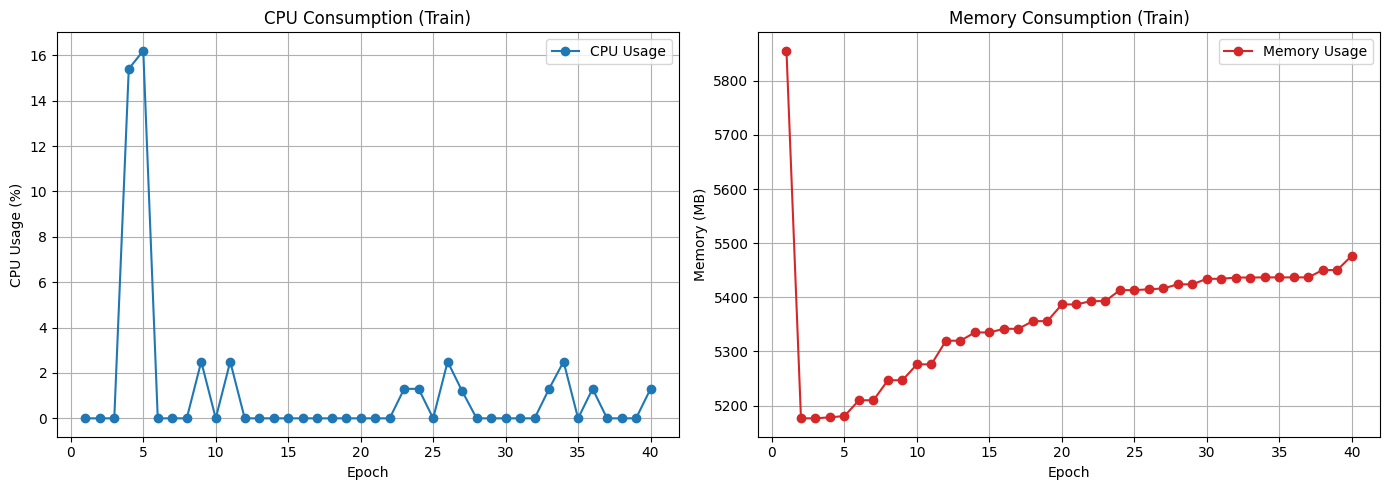

67676/67676 ━━━━━━━━━━━━━━━━━━━━ 54s 793us/step

====== General Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 12.84 seconds
Average CPU usage (Test): 2.25%
Average memory usage (Test): 5494.71 MB
Estimated energy consumption: 1162.56 Joules


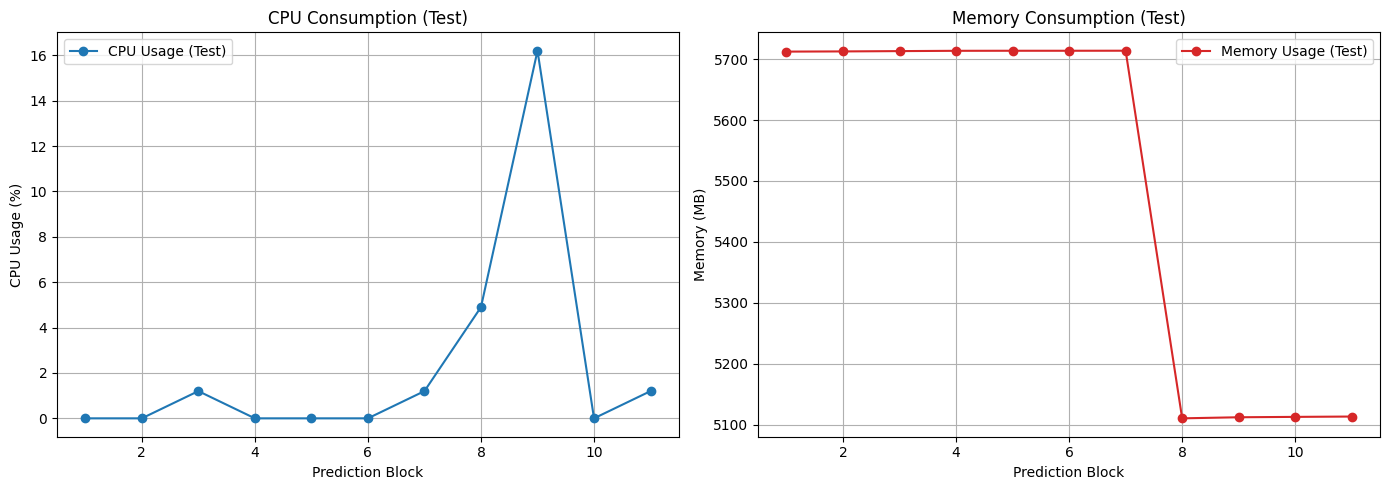

10774/10774 ━━━━━━━━━━━━━━━━━━━━ 8s 776us/step

====== Zero-Day Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 3.04 seconds
Average CPU usage (Test): 0.55%
Average memory usage (Test): 5318.15 MB
Estimated energy consumption: 4.15 Joules


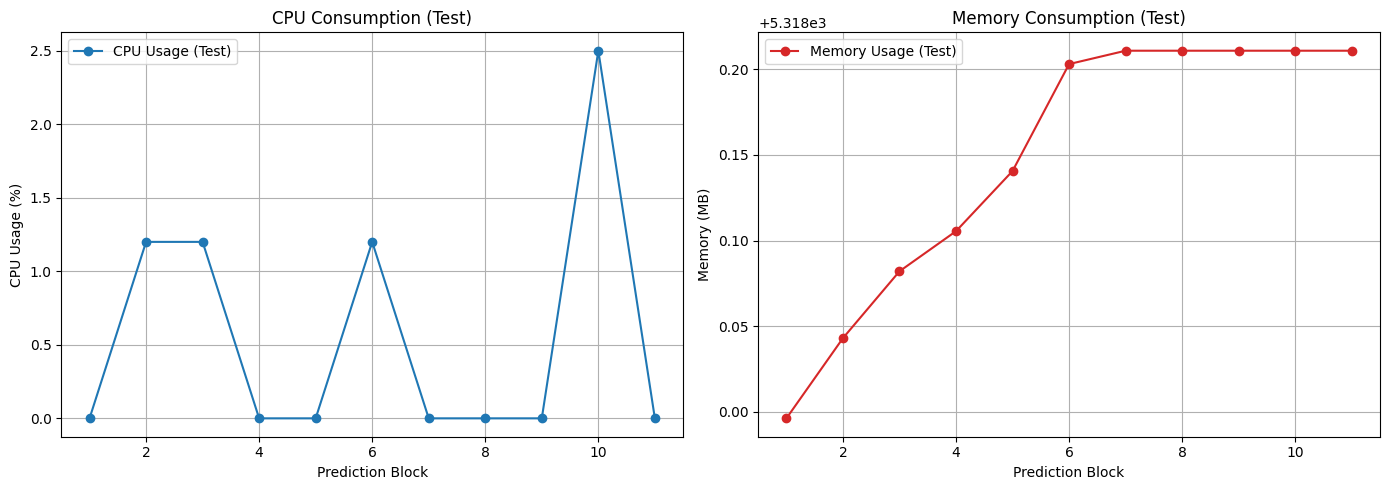

1237/1237 ━━━━━━━━━━━━━━━━━━━━ 1s 729us/step
10774/10774 ━━━━━━━━━━━━━━━━━━━━ 8s 714us/step
STD do reconstruction error: 150.7814052235446
ROC FULL gerada com AUC=0.5953
10774/10774 ━━━━━━━━━━━━━━━━━━━━ 8s 748us/step
STD do reconstruction error: 150.7814052235446
PR FULL gerada com AP=0.9154

====== Zero-Day: syn ======
Total syn in the original dataset: 506451
  Zero-days removed from training: 405095
  Zero-day in the original test: 101356
  Test full total: 344764

[Start of Training]

[Epoch 1 - Start] CPU: 0.00%, Memory: 5733.23 MB
[Epoch 1 - End] CPU: 0.00%, Memory: 5082.15 MB

[Epoch 2 - Start] CPU: 0.00%, Memory: 5082.12 MB
[Epoch 2 - End] CPU: 0.00%, Memory: 5096.88 MB

[Epoch 3 - Start] CPU: 2.50%, Memory: 5096.85 MB
[Epoch 3 - End] CPU: 0.00%, Memory: 5097.95 MB

[Epoch 4 - Start] CPU: 2.50%, Memory: 5097.93 MB
[Epoch 4 - End] CPU: 0.00%, Memory: 5124.95 MB

[Epoch 5 - Start] CPU: 1.30%, Memory: 5124.93 MB
[Epoch 5 - End] CPU: 0.00%, Memory: 5131.52 MB

[Epoch 6 - Start] CPU

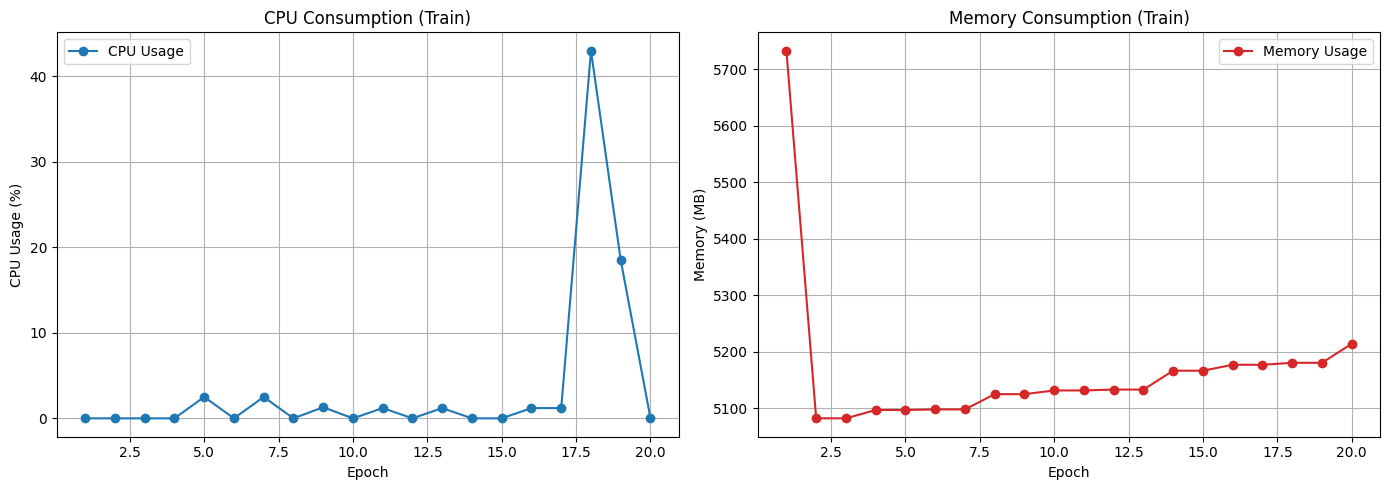

52340/52340 ━━━━━━━━━━━━━━━━━━━━ 44s 835us/step

====== General Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 13.22 seconds
Average CPU usage (Test): 4.16%
Average memory usage (Test): 5043.23 MB
Estimated energy consumption: 7632.87 Joules


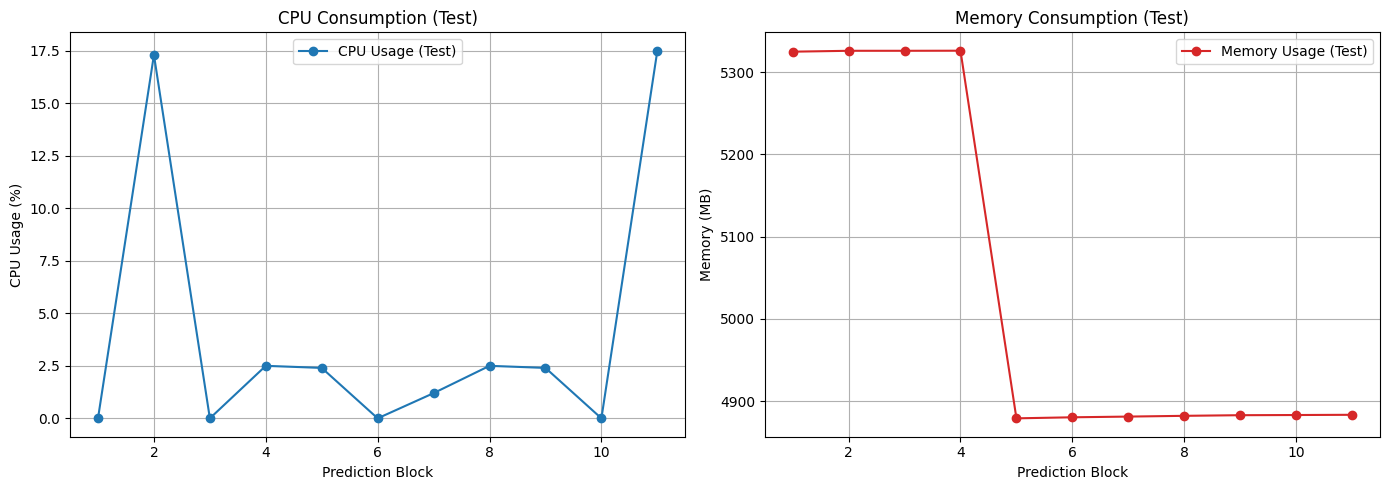

10774/10774 ━━━━━━━━━━━━━━━━━━━━ 9s 842us/step

====== Zero-Day Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 5.65 seconds
Average CPU usage (Test): 0.45%
Average memory usage (Test): 5101.15 MB
Estimated energy consumption: 4.24 Joules


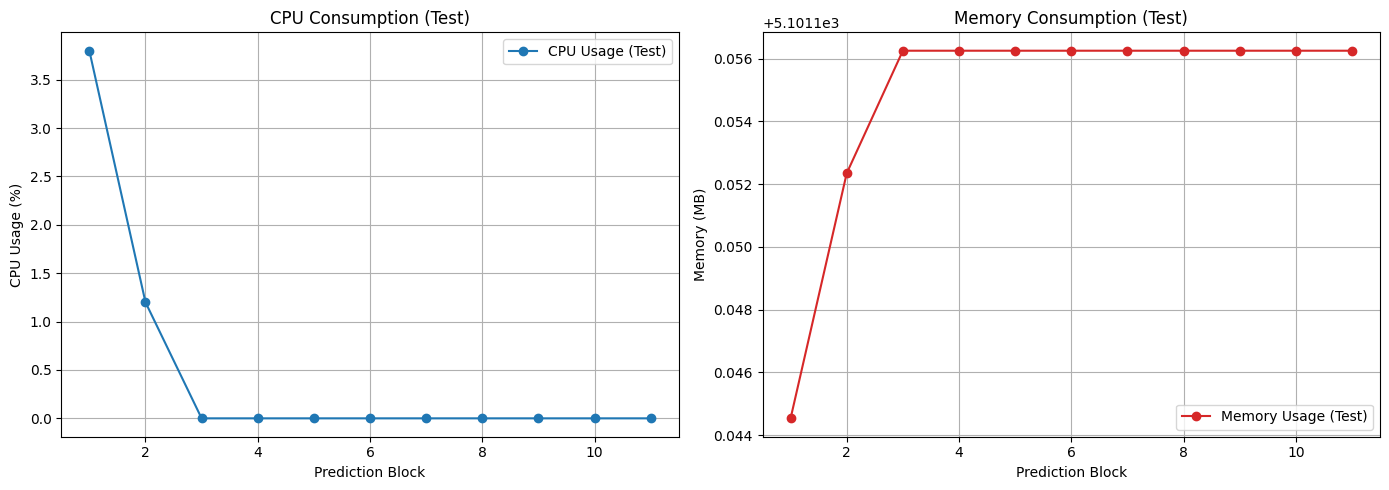

3168/3168 ━━━━━━━━━━━━━━━━━━━━ 3s 841us/step
10774/10774 ━━━━━━━━━━━━━━━━━━━━ 9s 837us/step
STD do reconstruction error: 129.73488462674203
ROC FULL gerada com AUC=0.5660
10774/10774 ━━━━━━━━━━━━━━━━━━━━ 9s 823us/step
STD do reconstruction error: 129.73488462674203
PR FULL gerada com AP=0.9011

====== Zero-Day: icmp ======
Total icmp in the original dataset: 24739
  Zero-days removed from training: 19756
  Zero-day in the original test: 4983
  Test full total: 344764

[Start of Training]

[Epoch 1 - Start] CPU: 2.50%, Memory: 6164.48 MB
[Epoch 1 - End] CPU: 17.50%, Memory: 5522.20 MB

[Epoch 2 - Start] CPU: 0.00%, Memory: 5522.18 MB
[Epoch 2 - End] CPU: 0.00%, Memory: 5566.71 MB

[Epoch 3 - Start] CPU: 3.70%, Memory: 5566.69 MB
[Epoch 3 - End] CPU: 15.00%, Memory: 5617.18 MB

[Epoch 4 - Start] CPU: 0.00%, Memory: 5617.16 MB
[Epoch 4 - End] CPU: 0.00%, Memory: 5637.51 MB

[Epoch 5 - Start] CPU: 0.00%, Memory: 5637.49 MB
[Epoch 5 - End] CPU: 0.00%, Memory: 5642.26 MB

[End of Training]
T

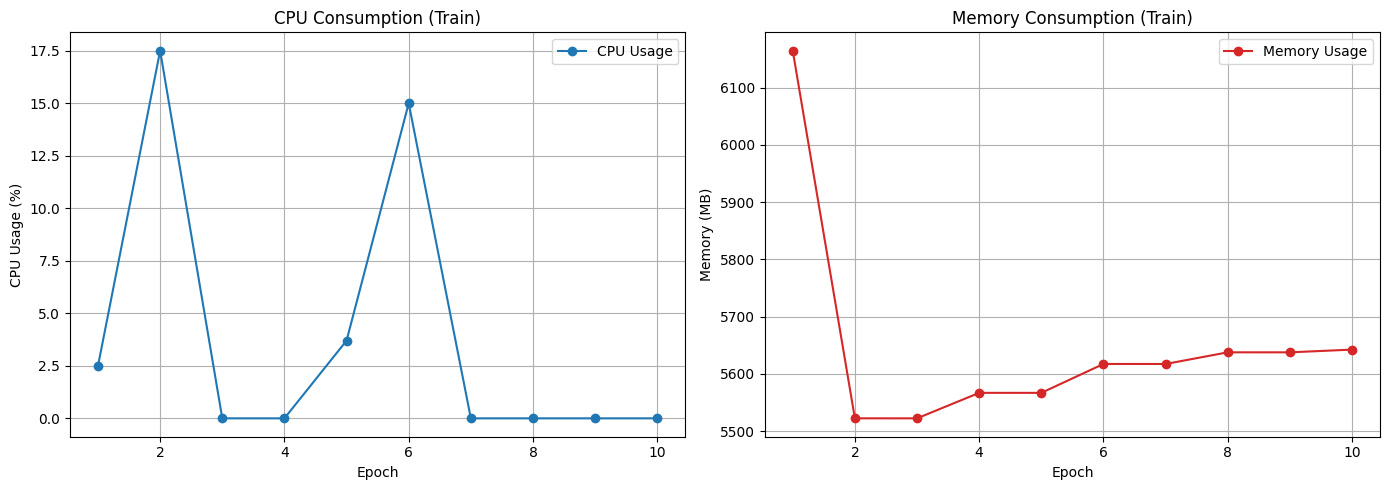

76424/76424 ━━━━━━━━━━━━━━━━━━━━ 61s 795us/step

====== General Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 13.54 seconds
Average CPU usage (Test): 1.60%
Average memory usage (Test): 5460.18 MB
Estimated energy consumption: 443.54 Joules


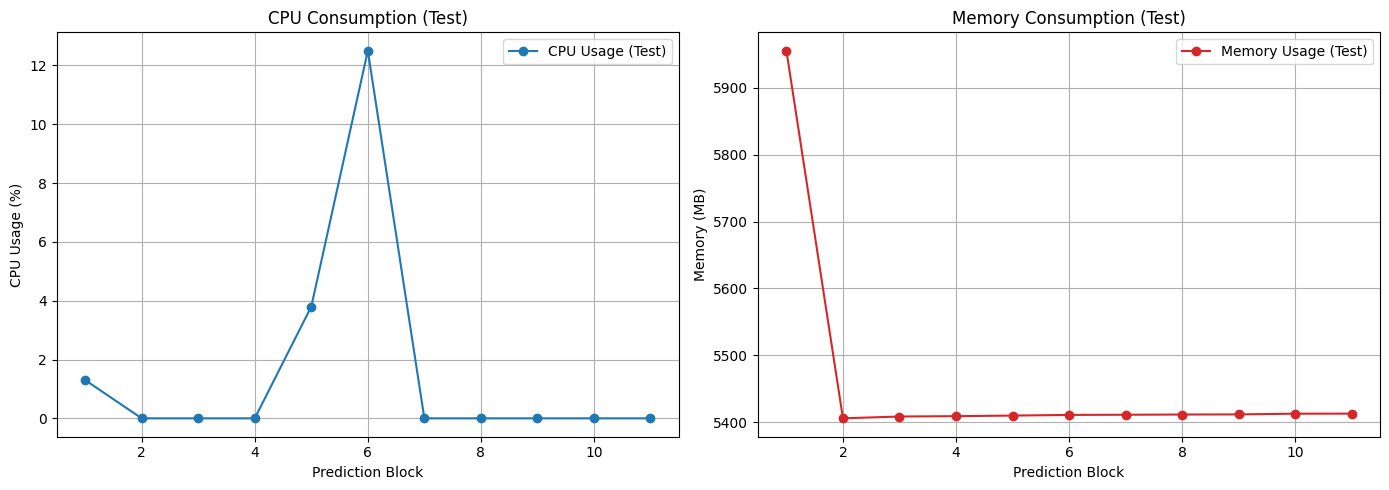

10774/10774 ━━━━━━━━━━━━━━━━━━━━ 9s 877us/step

====== Zero-Day Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 2.18 seconds
Average CPU usage (Test): 10.21%
Average memory usage (Test): 5610.25 MB
Estimated energy consumption: 18591.01 Joules


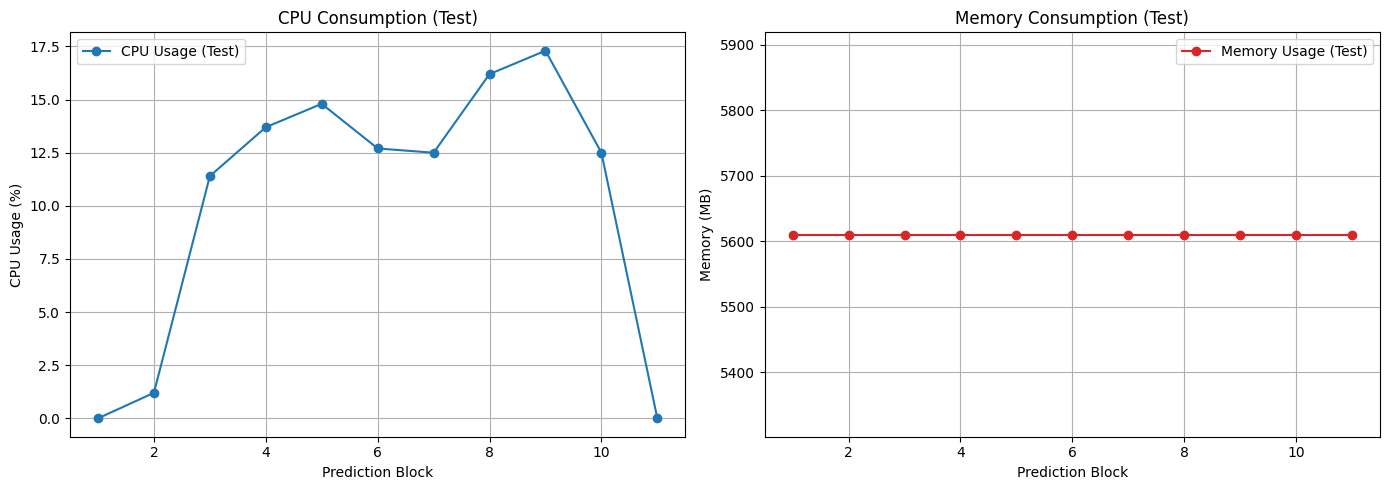

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step
10774/10774 ━━━━━━━━━━━━━━━━━━━━ 9s 797us/step
STD do reconstruction error: 283.08623483588786
ROC FULL gerada com AUC=0.6011
10774/10774 ━━━━━━━━━━━━━━━━━━━━ 8s 755us/step
STD do reconstruction error: 283.08623483588786
PR FULL gerada com AP=0.9184

====== Zero-Day: slowloris ======
Total slowloris in the original dataset: 94887
  Zero-days removed from training: 75934
  Zero-day in the original test: 18953
  Test full total: 344764

[Start of Training]

[Epoch 1 - Start] CPU: 12.80%, Memory: 6395.06 MB
[Epoch 1 - End] CPU: 13.60%, Memory: 5558.38 MB

[Epoch 2 - Start] CPU: 2.40%, Memory: 5558.39 MB
[Epoch 2 - End] CPU: 1.20%, Memory: 5617.07 MB

[Epoch 3 - Start] CPU: 0.00%, Memory: 5617.05 MB
[Epoch 3 - End] CPU: 3.70%, Memory: 5649.00 MB

[Epoch 4 - Start] CPU: 0.00%, Memory: 5648.98 MB
[Epoch 4 - End] CPU: 2.50%, Memory: 5651.36 MB

[Epoch 5 - Start] CPU: 0.00%, Memory: 5651.34 MB
[Epoch 5 - End] CPU: 1.20%, Memory: 5657.43 MB

[End of Tr

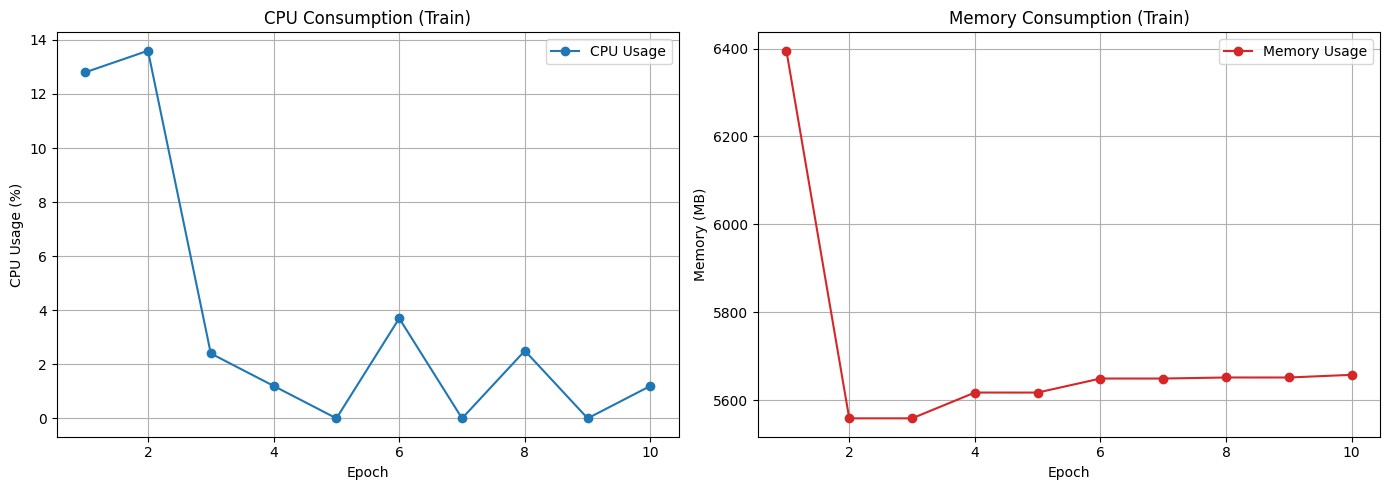

72912/72912 ━━━━━━━━━━━━━━━━━━━━ 58s 801us/step

====== General Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 12.37 seconds
Average CPU usage (Test): 3.30%
Average memory usage (Test): 5803.36 MB
Estimated energy consumption: 3556.31 Joules


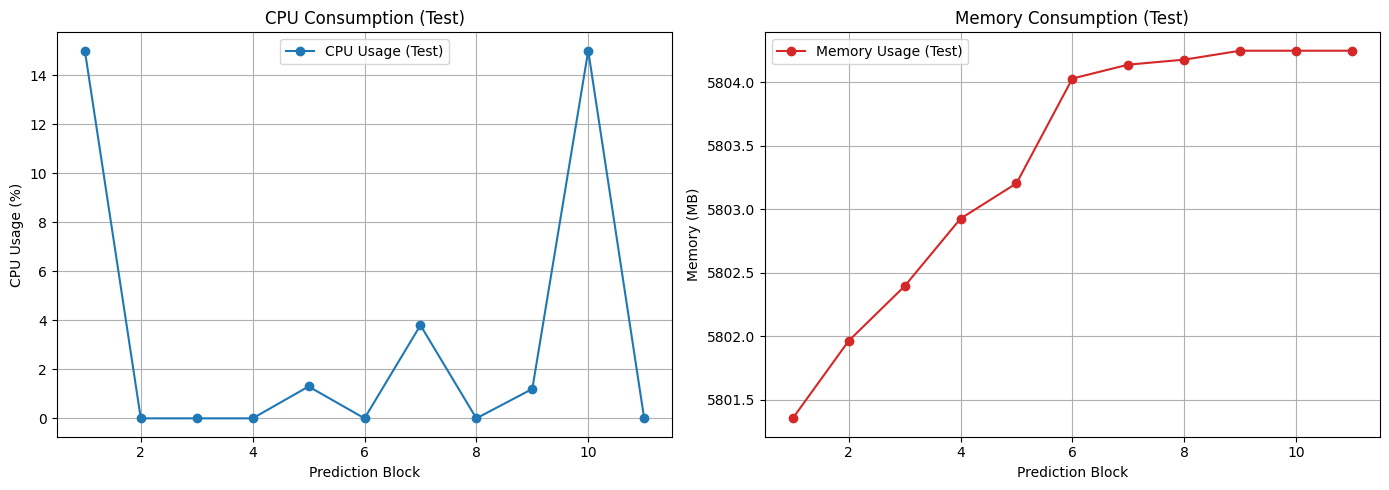

10774/10774 ━━━━━━━━━━━━━━━━━━━━ 8s 761us/step

====== Zero-Day Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 2.72 seconds
Average CPU usage (Test): 1.03%
Average memory usage (Test): 5907.86 MB
Estimated energy consumption: 23.59 Joules


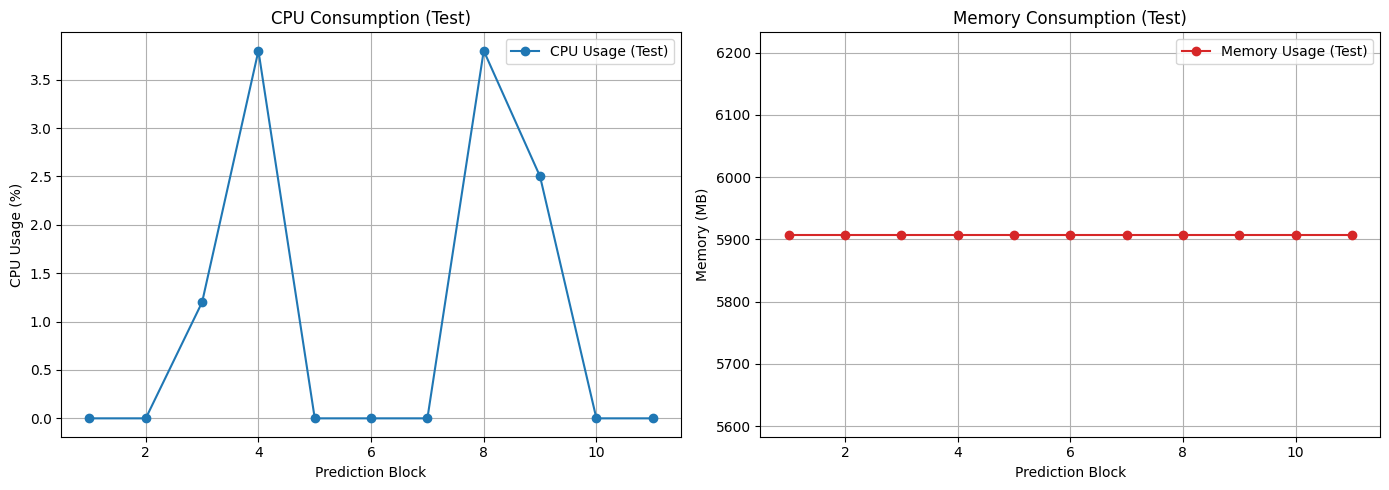

593/593 ━━━━━━━━━━━━━━━━━━━━ 1s 851us/step
10774/10774 ━━━━━━━━━━━━━━━━━━━━ 8s 770us/step
STD do reconstruction error: 283.8495103308905
ROC FULL gerada com AUC=0.6180
10774/10774 ━━━━━━━━━━━━━━━━━━━━ 9s 801us/step
STD do reconstruction error: 283.8495103308905
PR FULL gerada com AP=0.9202

====== Zero-Day: udp ======
Total udp in the original dataset: 227408
  Zero-days removed from training: 181655
  Zero-day in the original test: 45753
  Test full total: 344764

[Start of Training]

[Epoch 1 - Start] CPU: 0.00%, Memory: 5516.80 MB
[Epoch 1 - End] CPU: 14.80%, Memory: 5547.11 MB

[Epoch 2 - Start] CPU: 15.00%, Memory: 5547.09 MB
[Epoch 2 - End] CPU: 0.00%, Memory: 5612.99 MB

[Epoch 3 - Start] CPU: 1.20%, Memory: 5612.97 MB
[Epoch 3 - End] CPU: 0.00%, Memory: 5626.47 MB

[Epoch 4 - Start] CPU: 3.70%, Memory: 5626.45 MB
[Epoch 4 - End] CPU: 0.00%, Memory: 5657.64 MB

[Epoch 5 - Start] CPU: 16.30%, Memory: 5657.62 MB
[Epoch 5 - End] CPU: 2.50%, Memory: 5663.53 MB

[End of Training]
Tot

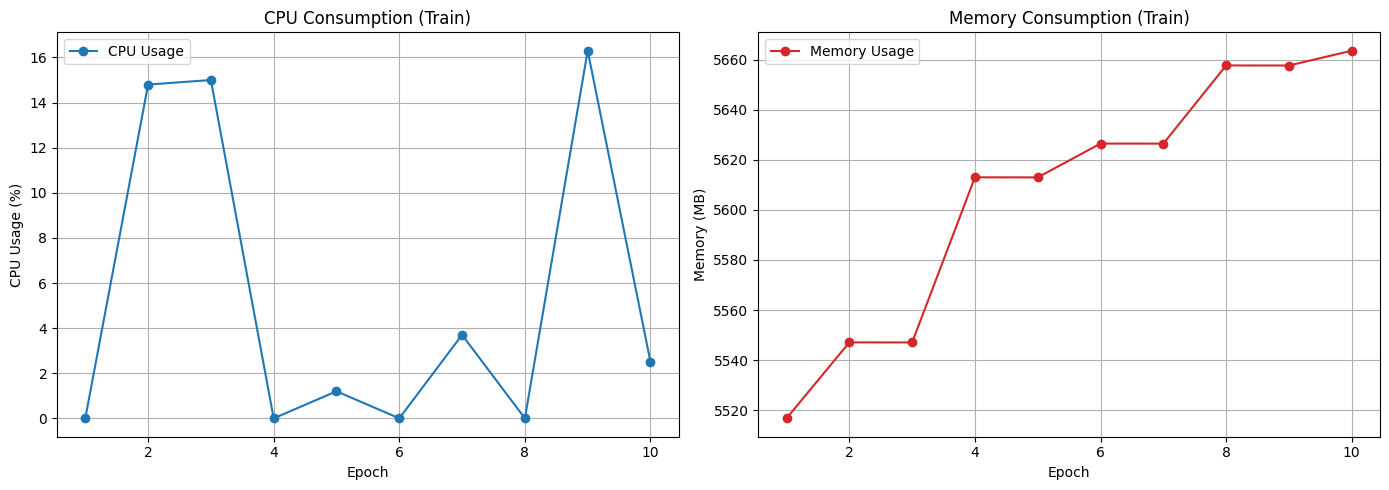

66305/66305 ━━━━━━━━━━━━━━━━━━━━ 53s 798us/step

====== General Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 13.46 seconds
Average CPU usage (Test): 1.72%
Average memory usage (Test): 5733.54 MB
Estimated energy consumption: 546.33 Joules


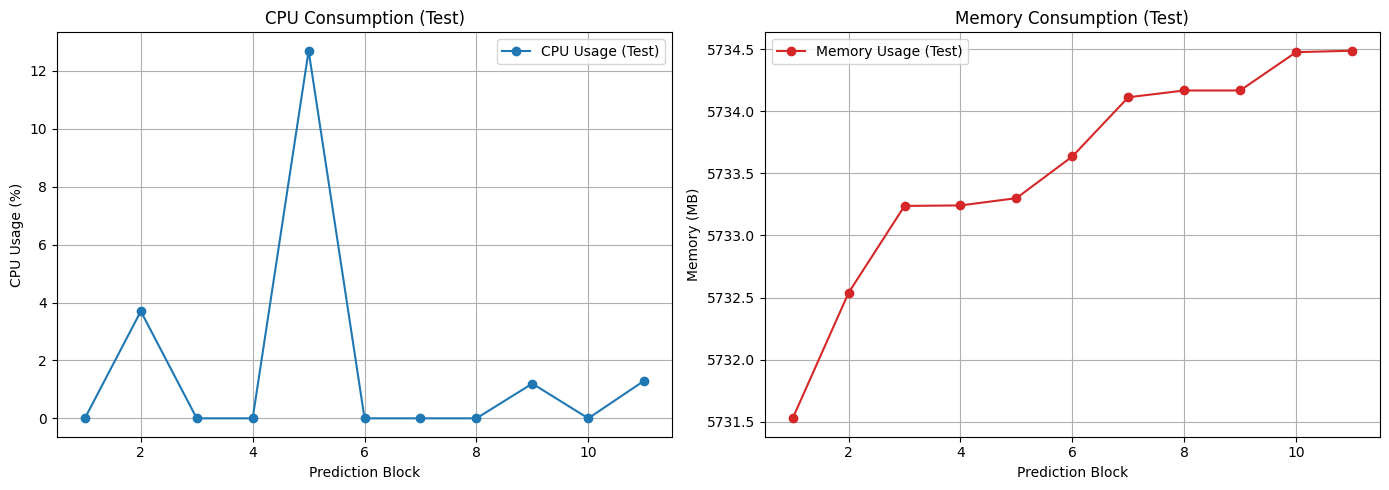

10774/10774 ━━━━━━━━━━━━━━━━━━━━ 8s 786us/step

====== Zero-Day Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 3.37 seconds
Average CPU usage (Test): 6.51%
Average memory usage (Test): 5819.89 MB
Estimated energy consumption: 7443.54 Joules


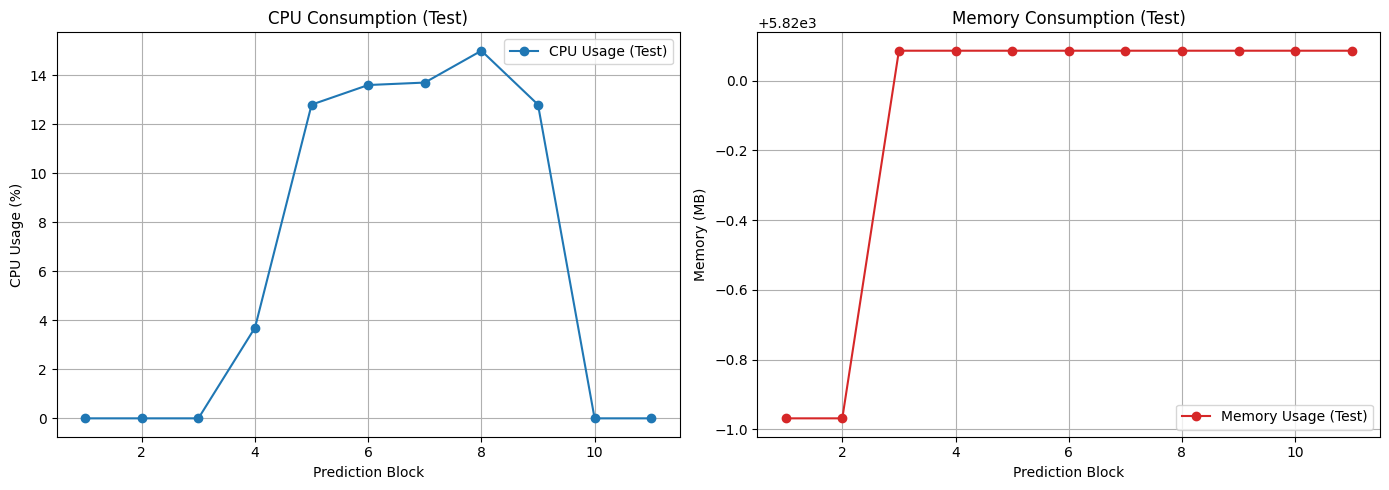

1430/1430 ━━━━━━━━━━━━━━━━━━━━ 1s 798us/step
10774/10774 ━━━━━━━━━━━━━━━━━━━━ 9s 822us/step
STD do reconstruction error: 142.73677980409548
ROC FULL gerada com AUC=0.6004
10774/10774 ━━━━━━━━━━━━━━━━━━━━ 9s 795us/step
STD do reconstruction error: 142.73677980409548
PR FULL gerada com AP=0.9127

====== Zero-Day: ssh ======
Total ssh in the original dataset: 14902
  Zero-days removed from training: 12009
  Zero-day in the original test: 2893
  Test full total: 344764

[Start of Training]

[Epoch 1 - Start] CPU: 1.30%, Memory: 6480.89 MB
[Epoch 1 - End] CPU: 2.50%, Memory: 5918.73 MB

[Epoch 2 - Start] CPU: 0.00%, Memory: 5918.70 MB
[Epoch 2 - End] CPU: 0.00%, Memory: 5964.17 MB

[Epoch 3 - Start] CPU: 1.20%, Memory: 5964.15 MB
[Epoch 3 - End] CPU: 1.30%, Memory: 5988.90 MB

[Epoch 4 - Start] CPU: 1.20%, Memory: 5988.88 MB
[Epoch 4 - End] CPU: 0.00%, Memory: 6004.38 MB

[Epoch 5 - Start] CPU: 0.00%, Memory: 6004.35 MB
[Epoch 5 - End] CPU: 1.20%, Memory: 6039.43 MB

[End of Training]
Total

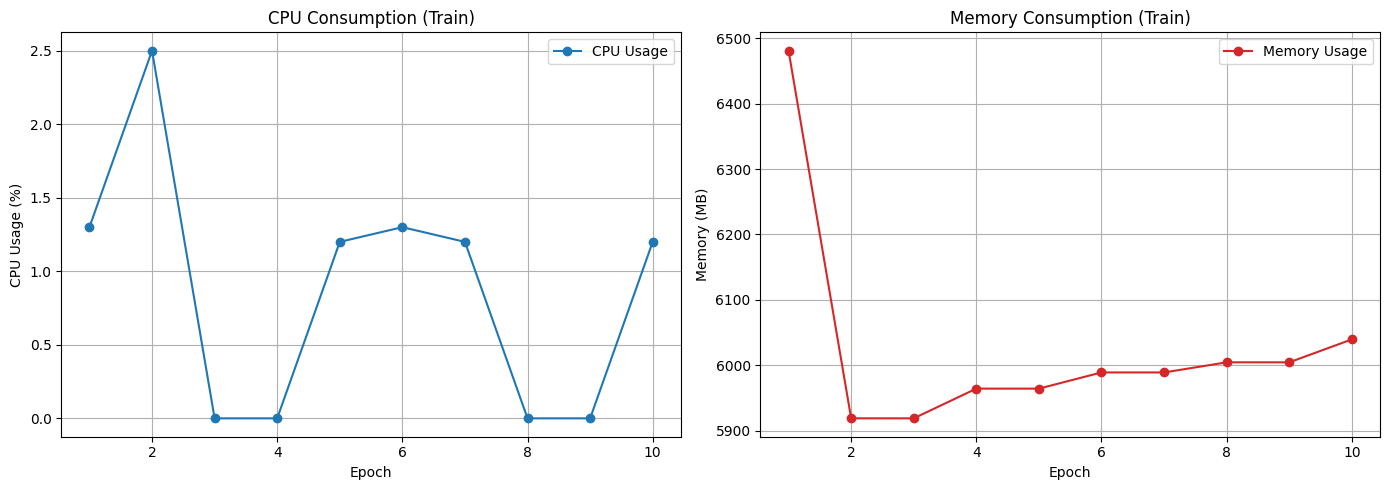

76908/76908 ━━━━━━━━━━━━━━━━━━━━ 65s 838us/step

====== General Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 13.78 seconds
Average CPU usage (Test): 3.40%
Average memory usage (Test): 6094.10 MB
Estimated energy consumption: 4331.36 Joules


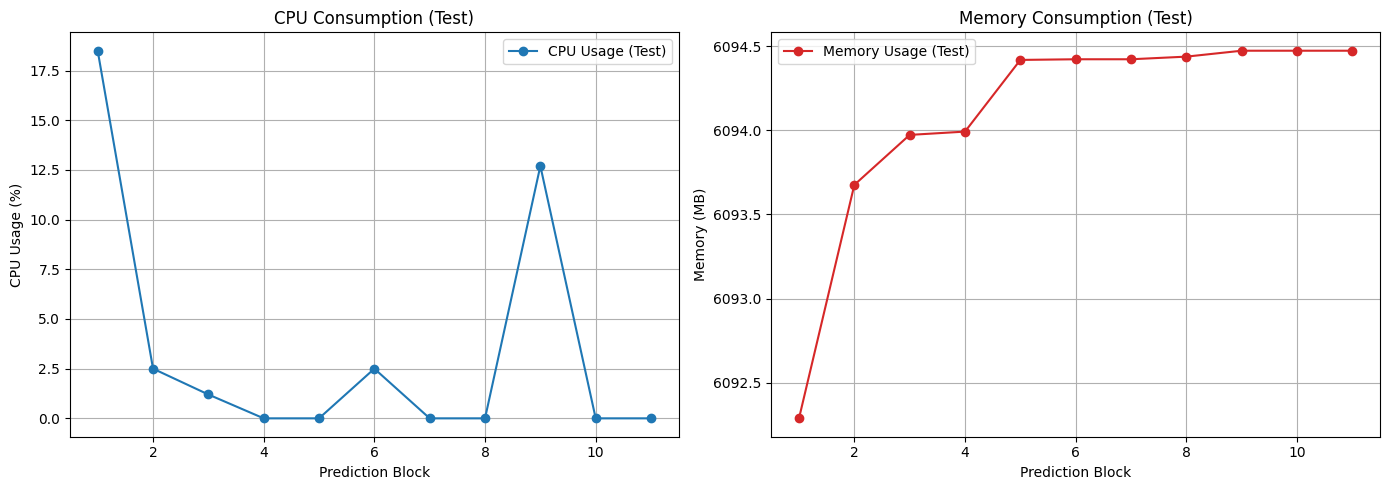

10774/10774 ━━━━━━━━━━━━━━━━━━━━ 9s 850us/step

====== Zero-Day Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 2.23 seconds
Average CPU usage (Test): 1.02%
Average memory usage (Test): 6092.44 MB
Estimated energy consumption: 18.84 Joules


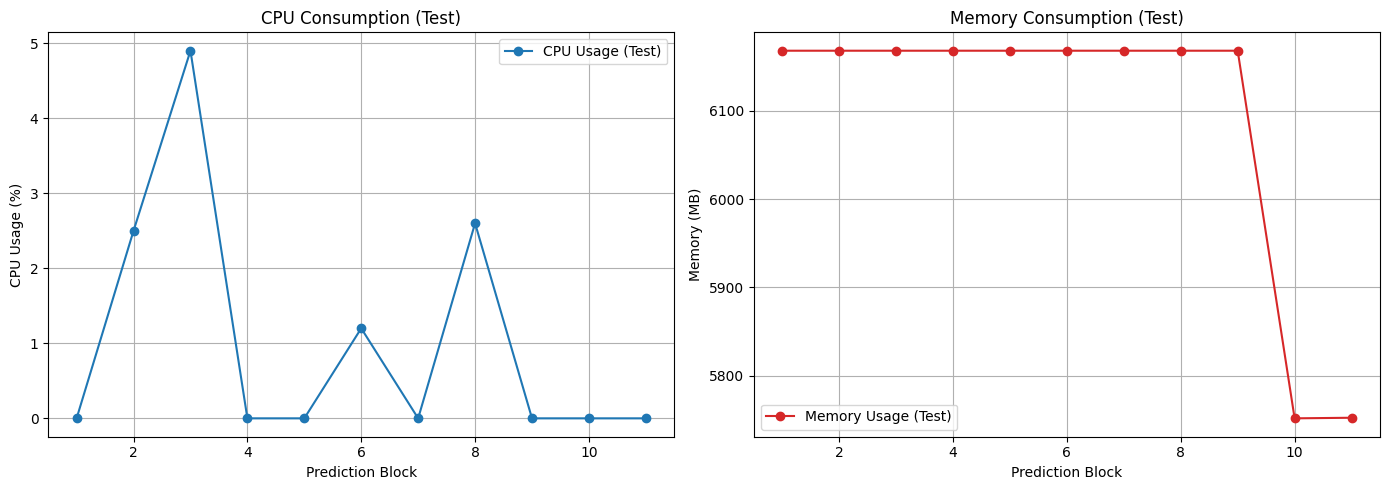

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
10774/10774 ━━━━━━━━━━━━━━━━━━━━ 9s 861us/step
STD do reconstruction error: 165.42035916403813
ROC FULL gerada com AUC=0.6001
10774/10774 ━━━━━━━━━━━━━━━━━━━━ 9s 863us/step
STD do reconstruction error: 165.42035916403813
PR FULL gerada com AP=0.9182

====== Zero-Day: ftp ======
Total ftp in the original dataset: 13664
  Zero-days removed from training: 10894
  Zero-day in the original test: 2770
  Test full total: 344764

[Start of Training]

[Epoch 1 - Start] CPU: 0.00%, Memory: 6657.56 MB
[Epoch 1 - End] CPU: 0.00%, Memory: 6104.41 MB

[Epoch 2 - Start] CPU: 0.00%, Memory: 6104.39 MB
[Epoch 2 - End] CPU: 2.40%, Memory: 6134.63 MB

[Epoch 3 - Start] CPU: 1.30%, Memory: 6134.61 MB
[Epoch 3 - End] CPU: 0.00%, Memory: 6143.91 MB

[Epoch 4 - Start] CPU: 0.00%, Memory: 6143.89 MB
[Epoch 4 - End] CPU: 2.50%, Memory: 6150.98 MB

[Epoch 5 - Start] CPU: 2.50%, Memory: 6150.96 MB
[Epoch 5 - End] CPU: 0.00%, Memory: 6159.61 MB

[End of Training]
Total tim

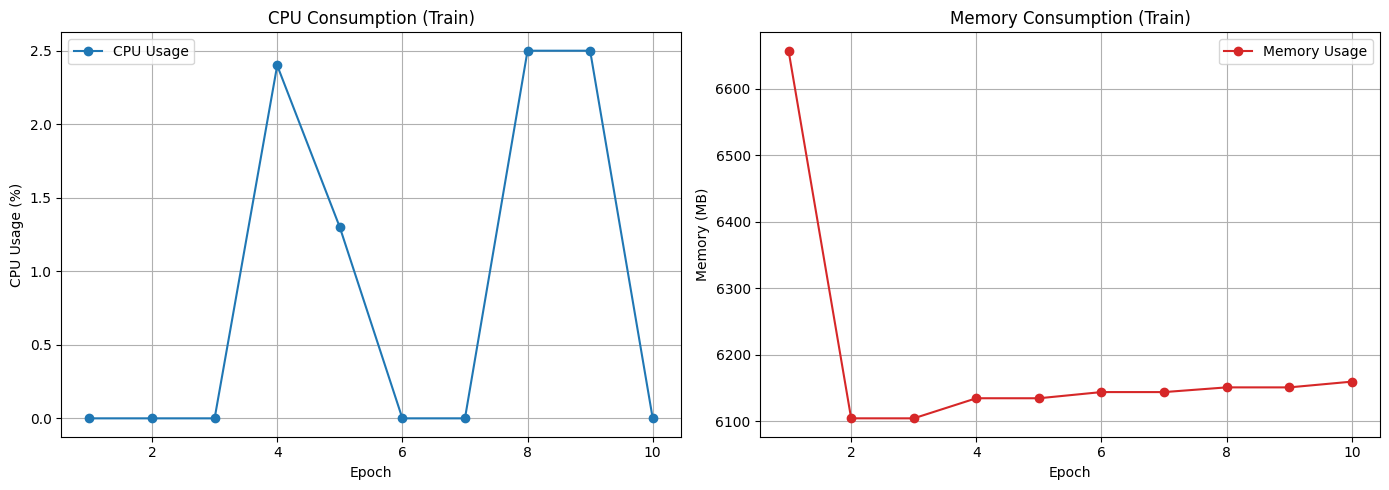

76977/76977 ━━━━━━━━━━━━━━━━━━━━ 62s 800us/step

====== General Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 14.11 seconds
Average CPU usage (Test): 2.50%
Average memory usage (Test): 6199.76 MB
Estimated energy consumption: 1763.45 Joules


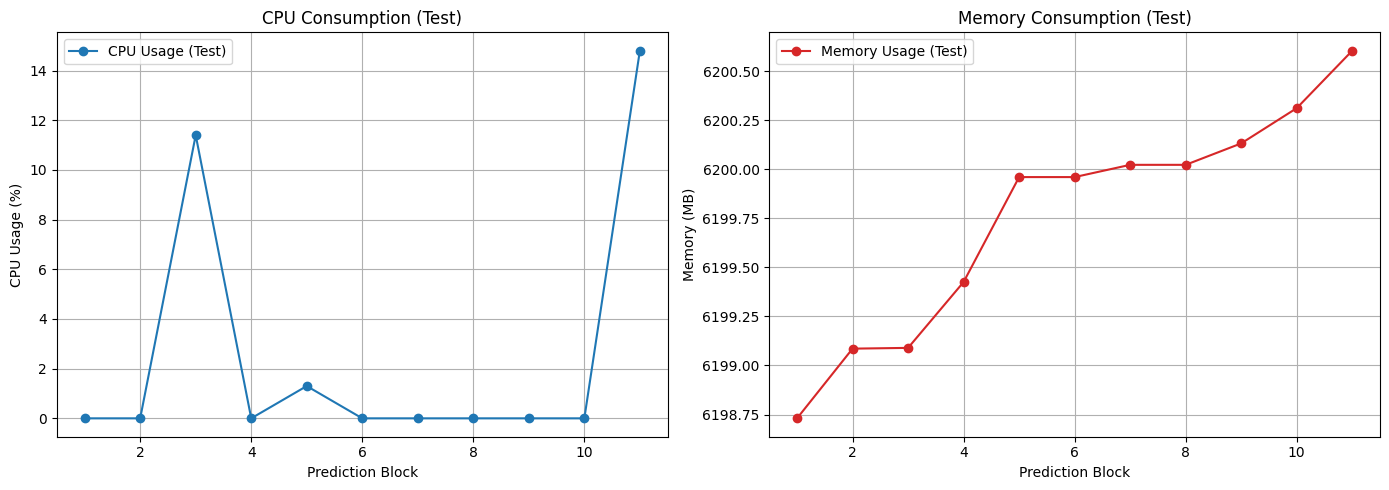

10774/10774 ━━━━━━━━━━━━━━━━━━━━ 10s 897us/step

====== Zero-Day Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 1.96 seconds
Average CPU usage (Test): 0.50%
Average memory usage (Test): 6124.27 MB
Estimated energy consumption: 1.96 Joules


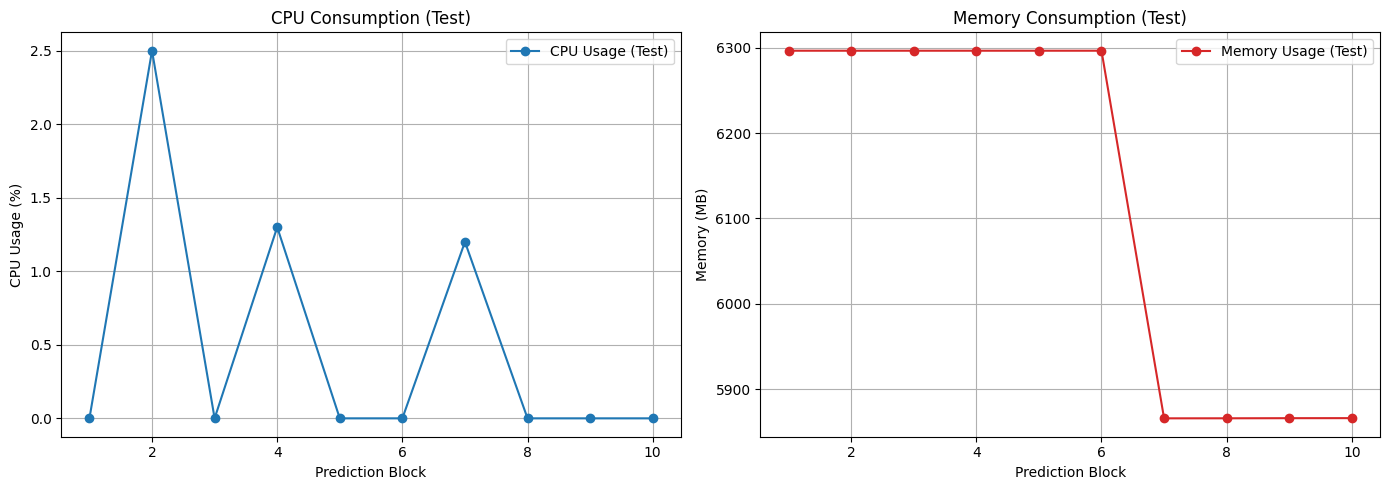

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
10774/10774 ━━━━━━━━━━━━━━━━━━━━ 9s 811us/step
STD do reconstruction error: 165.57734637934382
ROC FULL gerada com AUC=0.5994
10774/10774 ━━━━━━━━━━━━━━━━━━━━ 10s 920us/step
STD do reconstruction error: 165.57734637934382
PR FULL gerada com AP=0.9183

====== Zero-Day: portscan_tcp ======
Total portscan_tcp in the original dataset: 100000
  Zero-days removed from training: 80192
  Zero-day in the original test: 19808
  Test full total: 344764

[Start of Training]

[Epoch 1 - Start] CPU: 2.50%, Memory: 6710.71 MB
[Epoch 1 - End] CPU: 0.00%, Memory: 6055.21 MB

[Epoch 2 - Start] CPU: 0.00%, Memory: 6055.19 MB
[Epoch 2 - End] CPU: 1.20%, Memory: 6094.70 MB

[Epoch 3 - Start] CPU: 0.00%, Memory: 6094.68 MB
[Epoch 3 - End] CPU: 1.20%, Memory: 6136.09 MB

[Epoch 4 - Start] CPU: 1.30%, Memory: 6136.07 MB
[Epoch 4 - End] CPU: 1.30%, Memory: 6169.86 MB

[Epoch 5 - Start] CPU: 3.70%, Memory: 6169.84 MB
[Epoch 5 - End] CPU: 0.00%, Memory: 6191.61 MB

[End o

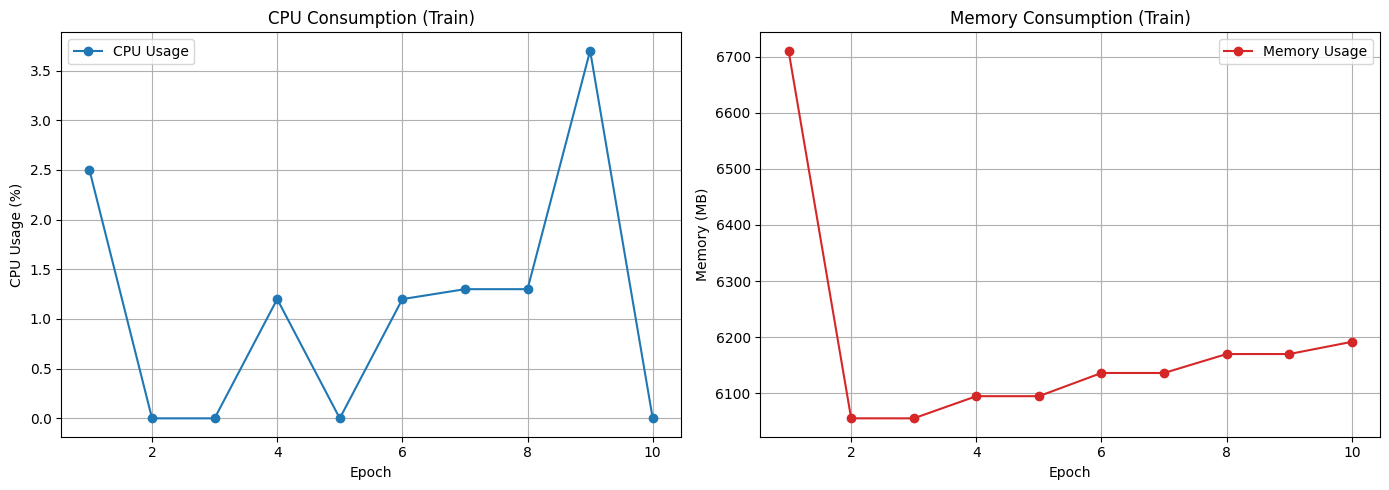

72646/72646 ━━━━━━━━━━━━━━━━━━━━ 63s 861us/step

====== General Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 15.37 seconds
Average CPU usage (Test): 1.46%
Average memory usage (Test): 6277.68 MB
Estimated energy consumption: 385.50 Joules


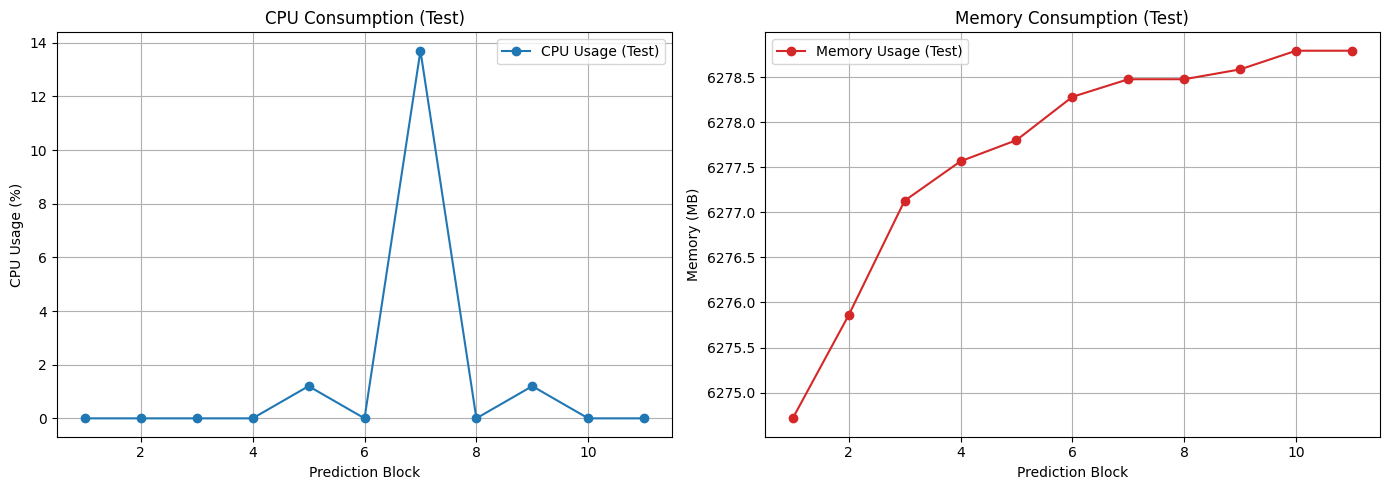

10774/10774 ━━━━━━━━━━━━━━━━━━━━ 9s 798us/step

====== Zero-Day Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 2.79 seconds
Average CPU usage (Test): 3.10%
Average memory usage (Test): 6089.78 MB
Estimated energy consumption: 665.21 Joules


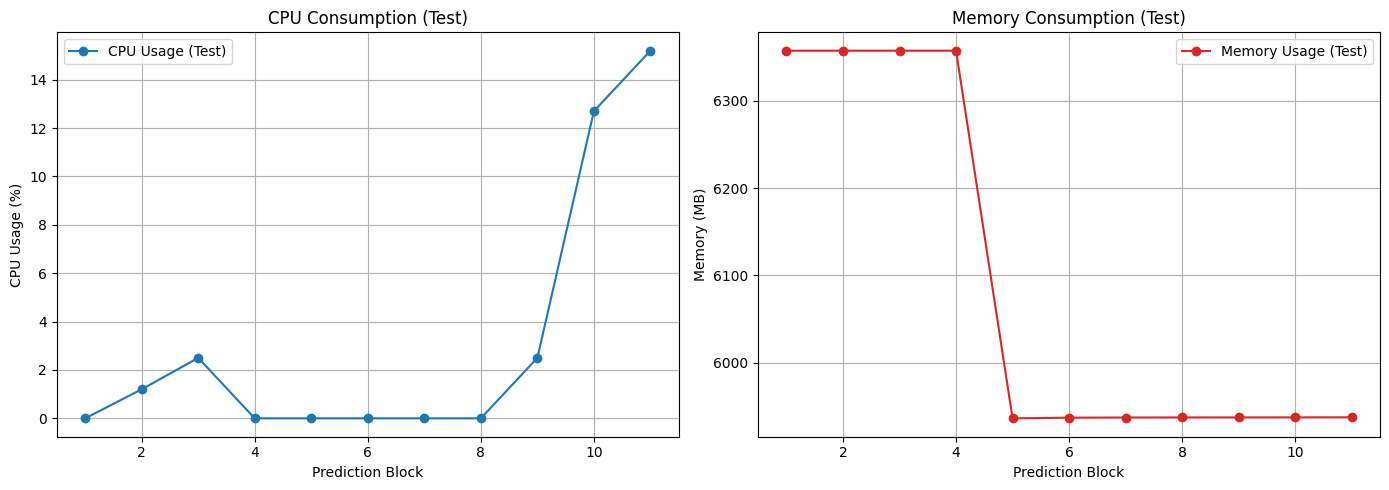

619/619 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
10774/10774 ━━━━━━━━━━━━━━━━━━━━ 9s 806us/step
STD do reconstruction error: 156.2817398769538
ROC FULL gerada com AUC=0.5973
10774/10774 ━━━━━━━━━━━━━━━━━━━━ 8s 742us/step
STD do reconstruction error: 156.2817398769538
PR FULL gerada com AP=0.9178

====== Zero-Day: os_fingerprinting ======
Total os_fingerprinting in the original dataset: 62957
  Zero-days removed from training: 50265
  Zero-day in the original test: 12692
  Test full total: 344764

[Start of Training]

[Epoch 1 - Start] CPU: 13.80%, Memory: 6864.55 MB
[Epoch 1 - End] CPU: 14.80%, Memory: 6302.17 MB

[Epoch 2 - Start] CPU: 3.80%, Memory: 6302.16 MB
[Epoch 2 - End] CPU: 0.00%, Memory: 6313.68 MB

[Epoch 3 - Start] CPU: 18.50%, Memory: 6315.57 MB
[Epoch 3 - End] CPU: 0.00%, Memory: 6351.25 MB

[Epoch 4 - Start] CPU: 2.50%, Memory: 6351.23 MB
[Epoch 4 - End] CPU: 1.20%, Memory: 6356.76 MB

[Epoch 5 - Start] CPU: 7.50%, Memory: 6356.73 MB
[Epoch 5 - End] CPU: 2.40%, Memory: 6359.11

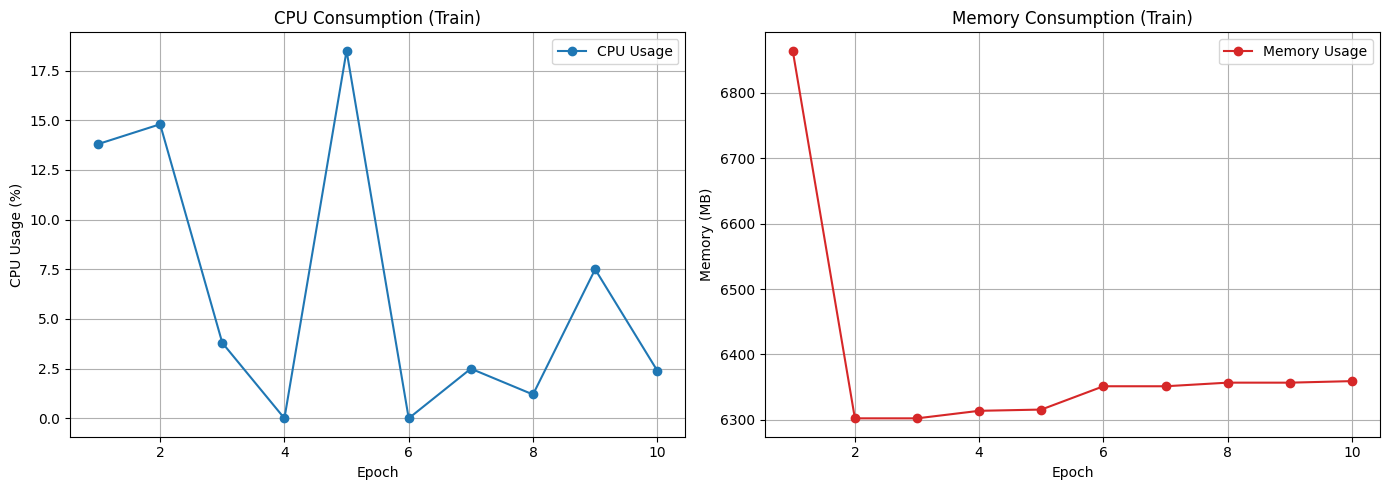

74517/74517 ━━━━━━━━━━━━━━━━━━━━ 70s 932us/step

====== General Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 13.54 seconds
Average CPU usage (Test): 2.03%
Average memory usage (Test): 6425.80 MB
Estimated energy consumption: 902.53 Joules


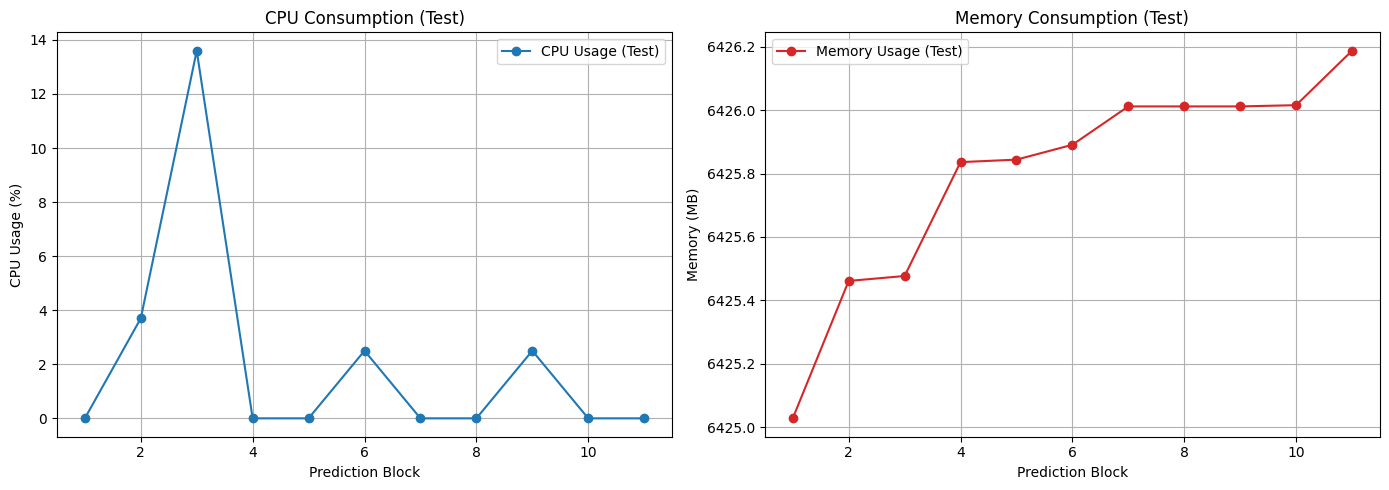

10774/10774 ━━━━━━━━━━━━━━━━━━━━ 9s 828us/step

====== Zero-Day Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 2.46 seconds
Average CPU usage (Test): 1.25%
Average memory usage (Test): 6134.29 MB
Estimated energy consumption: 38.00 Joules


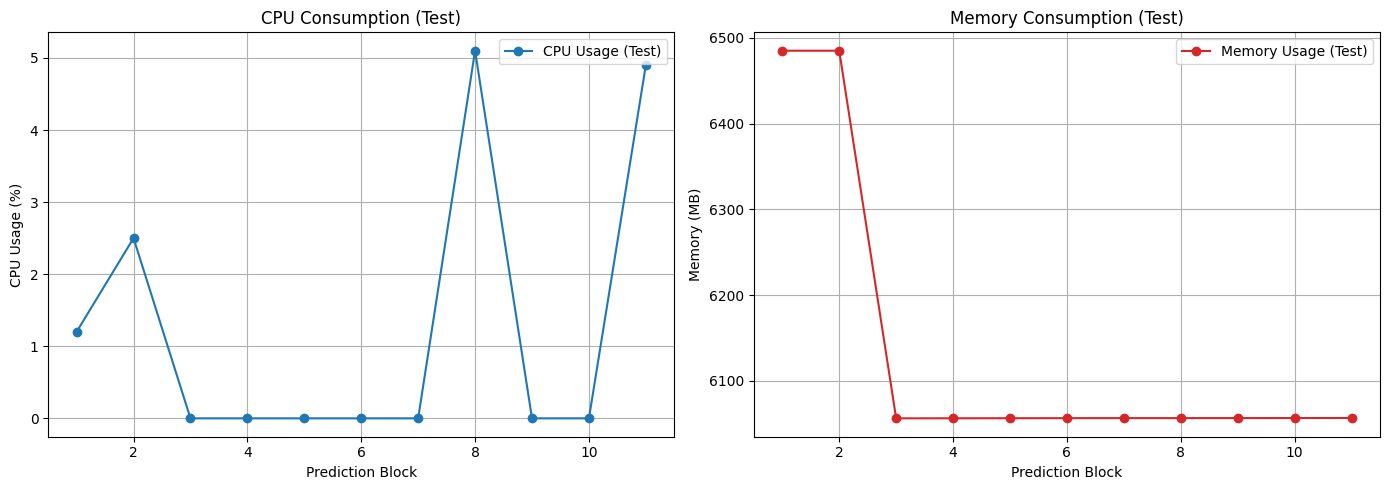

397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
10774/10774 ━━━━━━━━━━━━━━━━━━━━ 10s 939us/step
STD do reconstruction error: 160.31452426248728
ROC FULL gerada com AUC=0.6057
10774/10774 ━━━━━━━━━━━━━━━━━━━━ 9s 846us/step
STD do reconstruction error: 160.31452426248728
PR FULL gerada com AP=0.9185

====== Zero-Day: portscan_udp ======
Total portscan_udp in the original dataset: 20336
  Zero-days removed from training: 16281
  Zero-day in the original test: 4055
  Test full total: 344764

[Start of Training]

[Epoch 1 - Start] CPU: 1.20%, Memory: 7018.94 MB
[Epoch 1 - End] CPU: 0.00%, Memory: 6430.77 MB

[Epoch 2 - Start] CPU: 1.30%, Memory: 6430.75 MB
[Epoch 2 - End] CPU: 0.00%, Memory: 6489.51 MB

[Epoch 3 - Start] CPU: 2.50%, Memory: 6489.48 MB
[Epoch 3 - End] CPU: 1.20%, Memory: 6500.82 MB

[Epoch 4 - Start] CPU: 2.50%, Memory: 6500.80 MB
[Epoch 4 - End] CPU: 1.20%, Memory: 6558.61 MB

[Epoch 5 - Start] CPU: 2.50%, Memory: 6558.58 MB
[Epoch 5 - End] CPU: 0.00%, Memory: 6591.60 MB

[End o

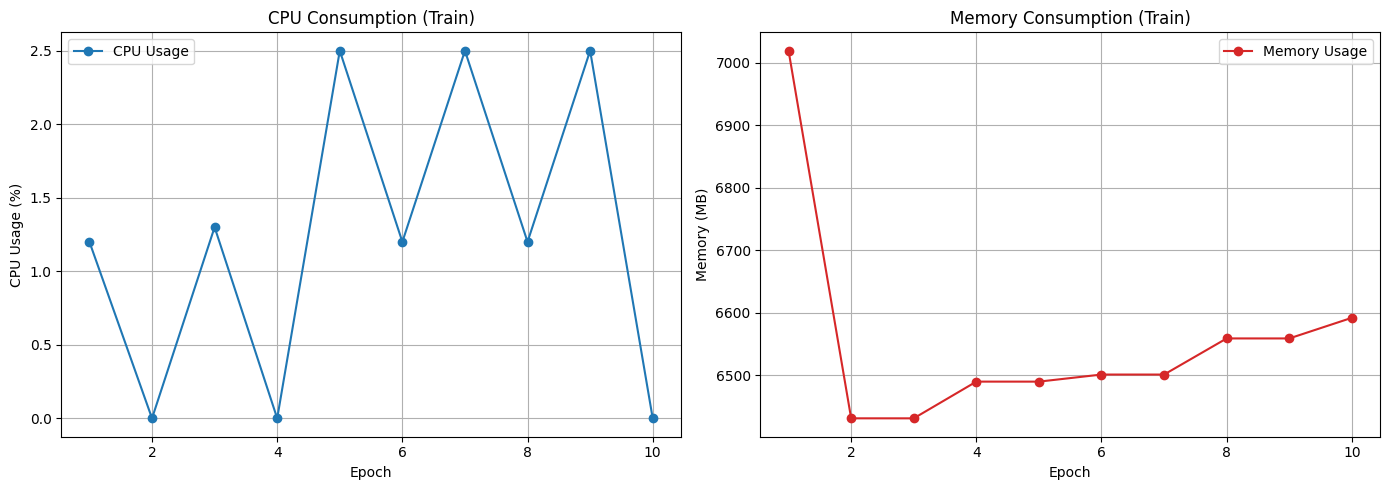

76641/76641 ━━━━━━━━━━━━━━━━━━━━ 65s 846us/step

====== General Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 13.24 seconds
Average CPU usage (Test): 1.69%
Average memory usage (Test): 6603.63 MB
Estimated energy consumption: 511.90 Joules


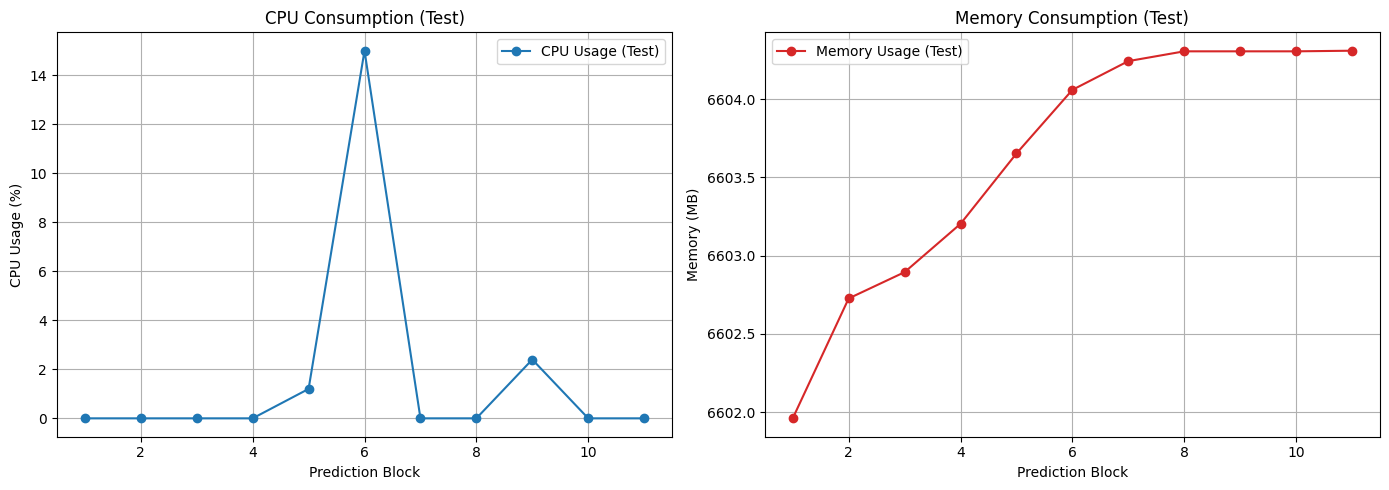

10774/10774 ━━━━━━━━━━━━━━━━━━━━ 8s 778us/step

====== Zero-Day Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 2.12 seconds
Average CPU usage (Test): 2.06%
Average memory usage (Test): 6400.46 MB
Estimated energy consumption: 148.84 Joules


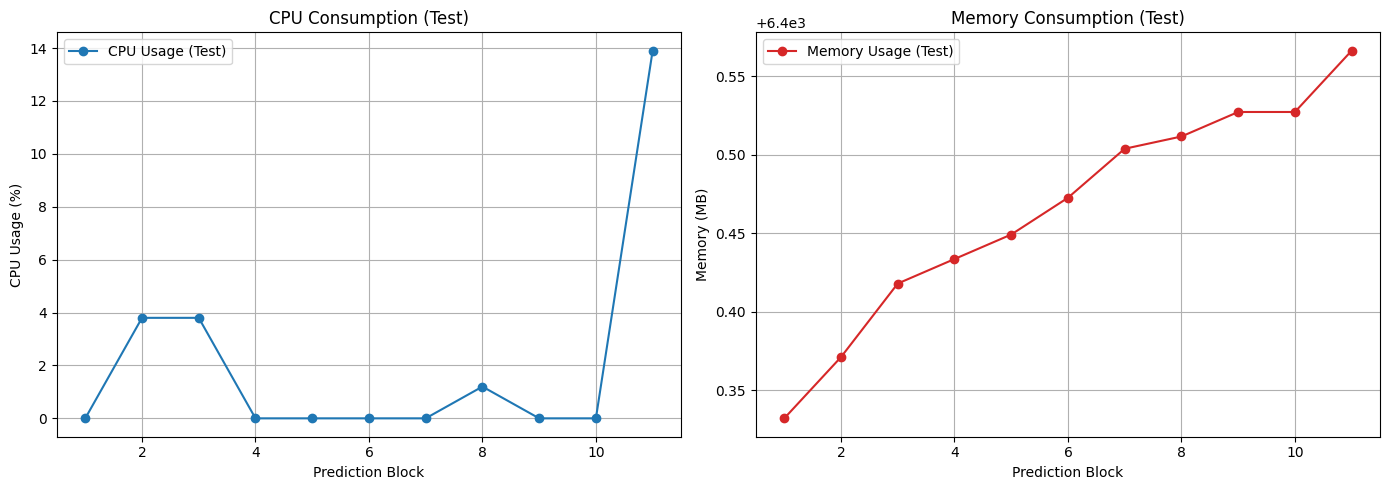

127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
10774/10774 ━━━━━━━━━━━━━━━━━━━━ 8s 760us/step
STD do reconstruction error: 164.84550243411041
ROC FULL gerada com AUC=0.6012
10774/10774 ━━━━━━━━━━━━━━━━━━━━ 9s 860us/step
STD do reconstruction error: 164.84550243411041
PR FULL gerada com AP=0.9186

====== Zero-Day: http_flood ======
Total http_flood in the original dataset: 254314
  Zero-days removed from training: 203559
  Zero-day in the original test: 50755
  Test full total: 344764

[Start of Training]

[Epoch 1 - Start] CPU: 0.00%, Memory: 6794.32 MB
[Epoch 1 - End] CPU: 1.30%, Memory: 6290.57 MB

[Epoch 2 - Start] CPU: 1.30%, Memory: 6284.10 MB
[Epoch 2 - End] CPU: 0.00%, Memory: 6317.65 MB

[Epoch 3 - Start] CPU: 1.30%, Memory: 6326.29 MB
[Epoch 3 - End] CPU: 14.80%, Memory: 6341.51 MB

[Epoch 4 - Start] CPU: 17.50%, Memory: 6341.48 MB
[Epoch 4 - End] CPU: 15.00%, Memory: 6379.46 MB

[Epoch 5 - Start] CPU: 21.20%, Memory: 6379.43 MB
[Epoch 5 - End] CPU: 3.70%, Memory: 6379.93 MB

[End

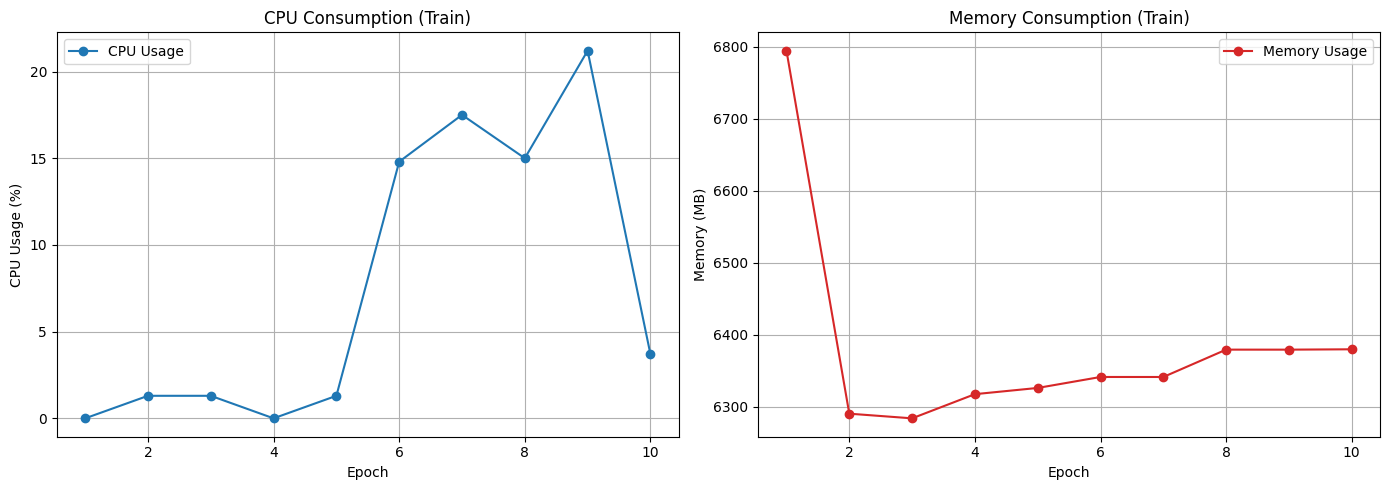

64936/64936 ━━━━━━━━━━━━━━━━━━━━ 57s 879us/step

====== General Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 13.44 seconds
Average CPU usage (Test): 3.40%
Average memory usage (Test): 6371.78 MB
Estimated energy consumption: 4225.54 Joules


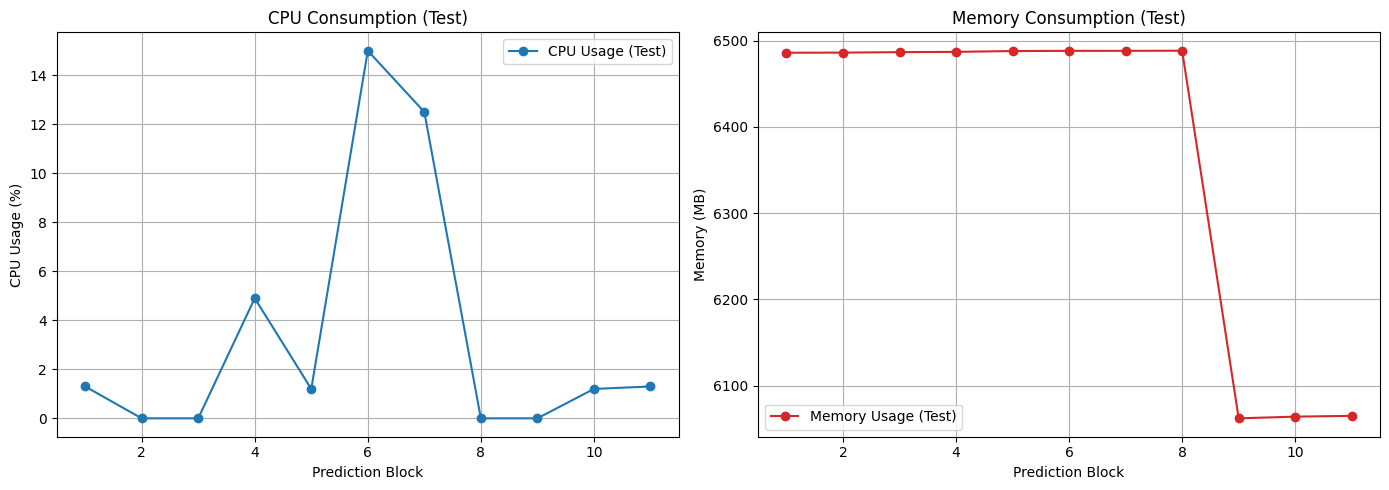

10774/10774 ━━━━━━━━━━━━━━━━━━━━ 9s 837us/step

====== Zero-Day Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 3.69 seconds
Average CPU usage (Test): 6.25%
Average memory usage (Test): 6269.30 MB
Estimated energy consumption: 7181.76 Joules


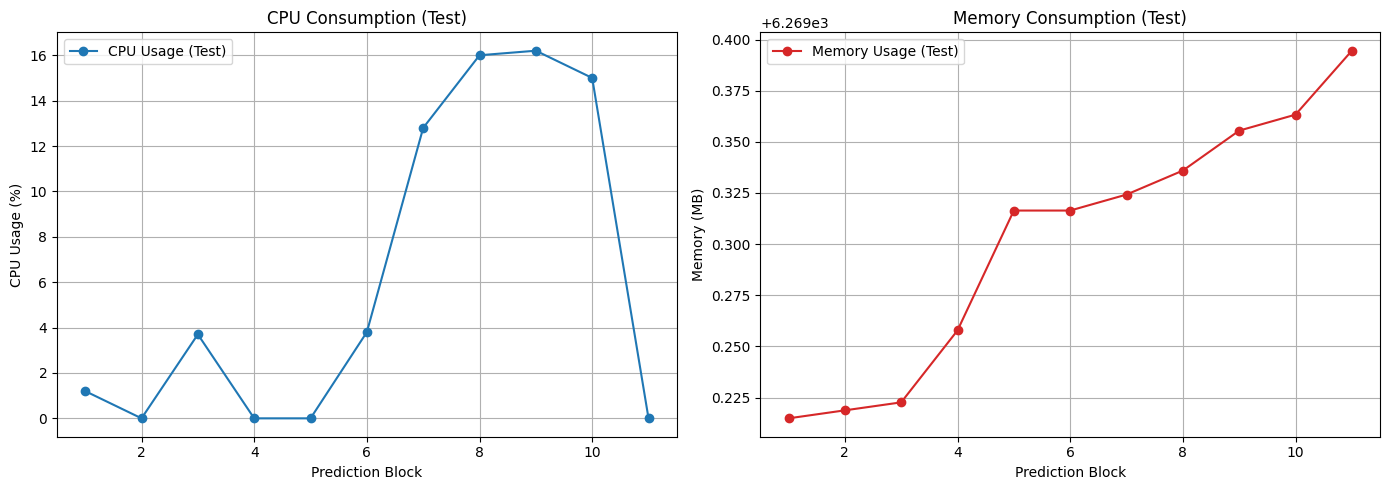

1587/1587 ━━━━━━━━━━━━━━━━━━━━ 2s 946us/step
10774/10774 ━━━━━━━━━━━━━━━━━━━━ 10s 923us/step
STD do reconstruction error: 139.73173612403883
ROC FULL gerada com AUC=0.4616
10774/10774 ━━━━━━━━━━━━━━━━━━━━ 9s 879us/step
STD do reconstruction error: 139.73173612403883
PR FULL gerada com AP=0.9080

====== Zero-Day: dir_bruteforce ======
Total dir_bruteforce in the original dataset: 28566
  Zero-days removed from training: 22843
  Zero-day in the original test: 5723
  Test full total: 344764

[Start of Training]

[Epoch 1 - Start] CPU: 0.00%, Memory: 7131.00 MB
[Epoch 1 - End] CPU: 1.20%, Memory: 6589.78 MB

[Epoch 2 - Start] CPU: 6.20%, Memory: 6589.76 MB
[Epoch 2 - End] CPU: 0.00%, Memory: 6630.40 MB

[Epoch 3 - Start] CPU: 2.50%, Memory: 6630.38 MB
[Epoch 3 - End] CPU: 0.00%, Memory: 6633.39 MB

[Epoch 4 - Start] CPU: 0.00%, Memory: 6633.36 MB
[Epoch 4 - End] CPU: 1.30%, Memory: 6667.80 MB

[Epoch 5 - Start] CPU: 3.70%, Memory: 6667.77 MB
[Epoch 5 - End] CPU: 0.00%, Memory: 6667.93 MB



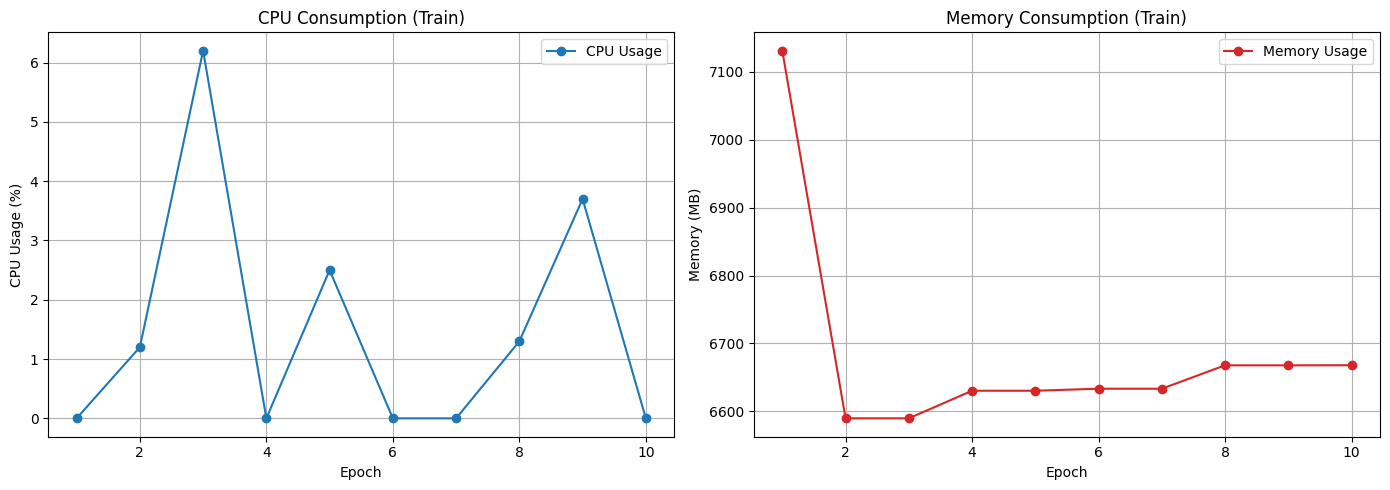

76231/76231 ━━━━━━━━━━━━━━━━━━━━ 62s 808us/step

====== General Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 12.94 seconds
Average CPU usage (Test): 2.13%
Average memory usage (Test): 6560.43 MB
Estimated energy consumption: 996.41 Joules


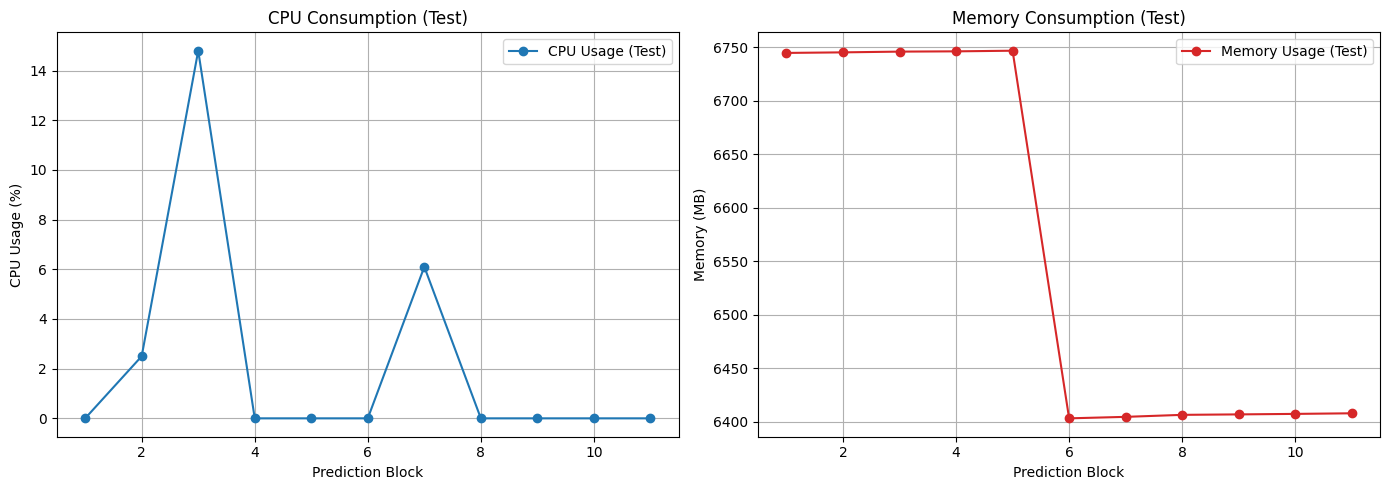

10774/10774 ━━━━━━━━━━━━━━━━━━━━ 9s 810us/step

====== Zero-Day Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 2.13 seconds
Average CPU usage (Test): 0.80%
Average memory usage (Test): 6608.55 MB
Estimated energy consumption: 8.73 Joules


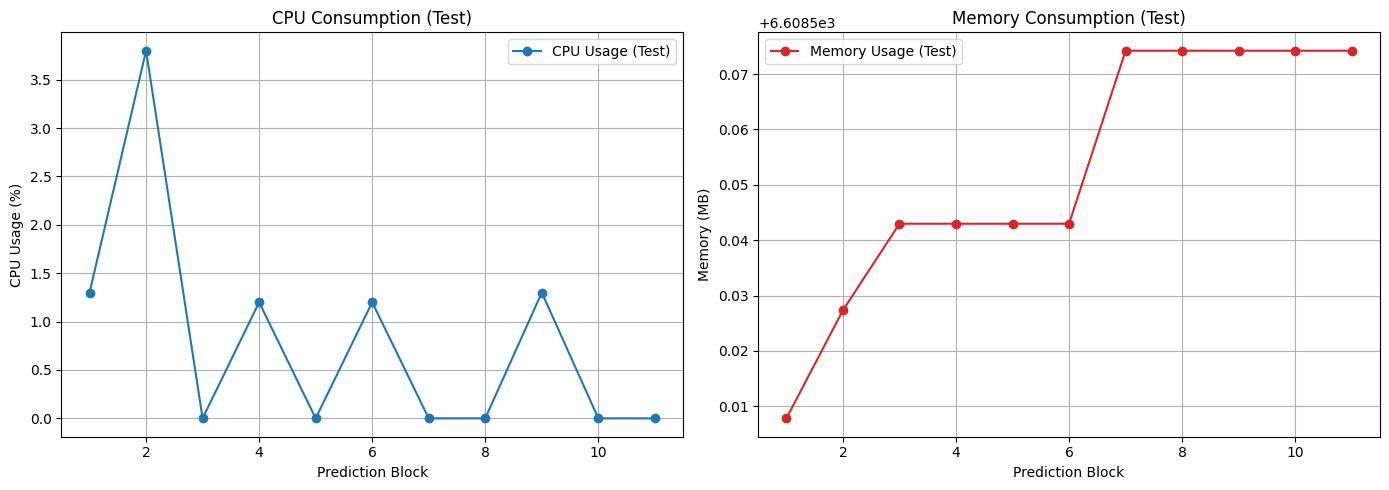

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step
10774/10774 ━━━━━━━━━━━━━━━━━━━━ 9s 805us/step
STD do reconstruction error: 163.97021506538528
ROC FULL gerada com AUC=0.5915
10774/10774 ━━━━━━━━━━━━━━━━━━━━ 8s 768us/step
STD do reconstruction error: 163.97021506538528
PR FULL gerada com AP=0.9207

====== Zero-Day: xss ======
Total xss in the original dataset: 3661
  Zero-days removed from training: 2893
  Zero-day in the original test: 768
  Test full total: 344764

[Start of Training]

[Epoch 1 - Start] CPU: 2.50%, Memory: 7338.26 MB
[Epoch 1 - End] CPU: 0.00%, Memory: 6694.57 MB

[Epoch 2 - Start] CPU: 2.50%, Memory: 6694.55 MB
[Epoch 2 - End] CPU: 1.30%, Memory: 6761.42 MB

[Epoch 3 - Start] CPU: 0.00%, Memory: 6761.39 MB
[Epoch 3 - End] CPU: 0.00%, Memory: 6783.82 MB

[Epoch 4 - Start] CPU: 7.60%, Memory: 6783.80 MB
[Epoch 4 - End] CPU: 0.00%, Memory: 6798.98 MB

[Epoch 5 - Start] CPU: 2.50%, Memory: 6800.52 MB
[Epoch 5 - End] CPU: 13.70%, Memory: 6801.25 MB

[End of Training]
Total tim

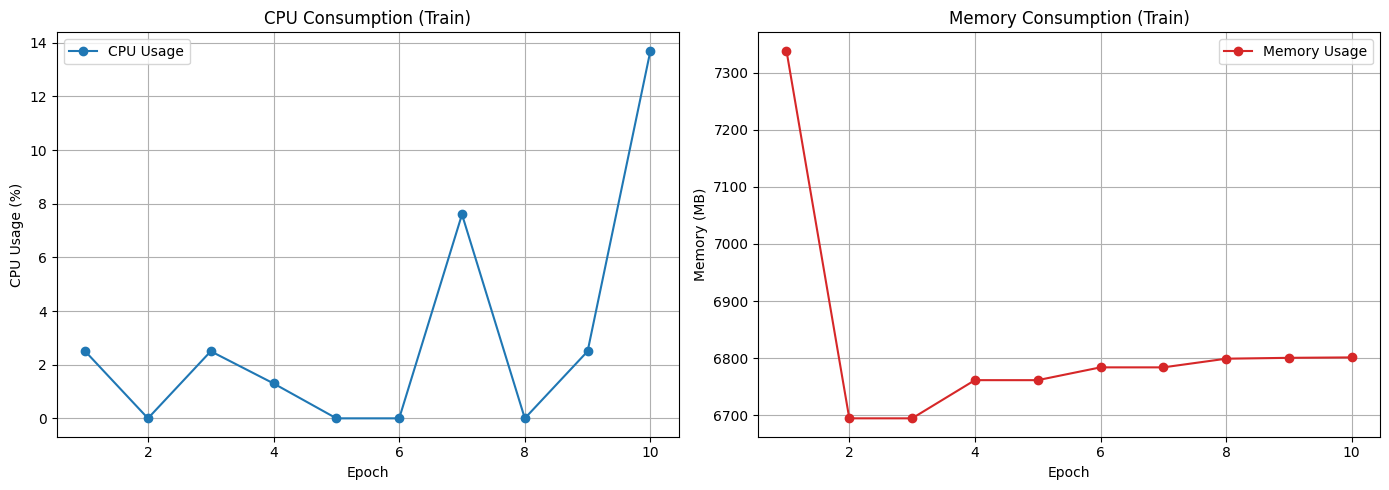

77477/77477 ━━━━━━━━━━━━━━━━━━━━ 63s 813us/step

====== General Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 15.78 seconds
Average CPU usage (Test): 3.50%
Average memory usage (Test): 6604.22 MB
Estimated energy consumption: 5413.82 Joules


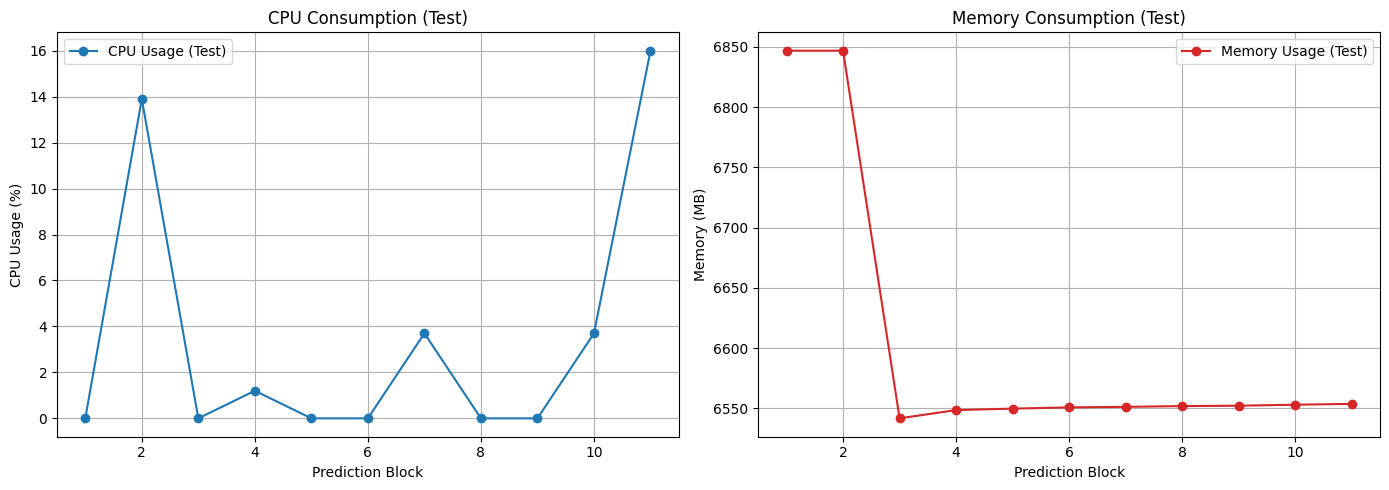

10774/10774 ━━━━━━━━━━━━━━━━━━━━ 10s 920us/step

====== Zero-Day Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 2.20 seconds
Average CPU usage (Test): 1.14%
Average memory usage (Test): 6758.51 MB
Estimated energy consumption: 25.80 Joules


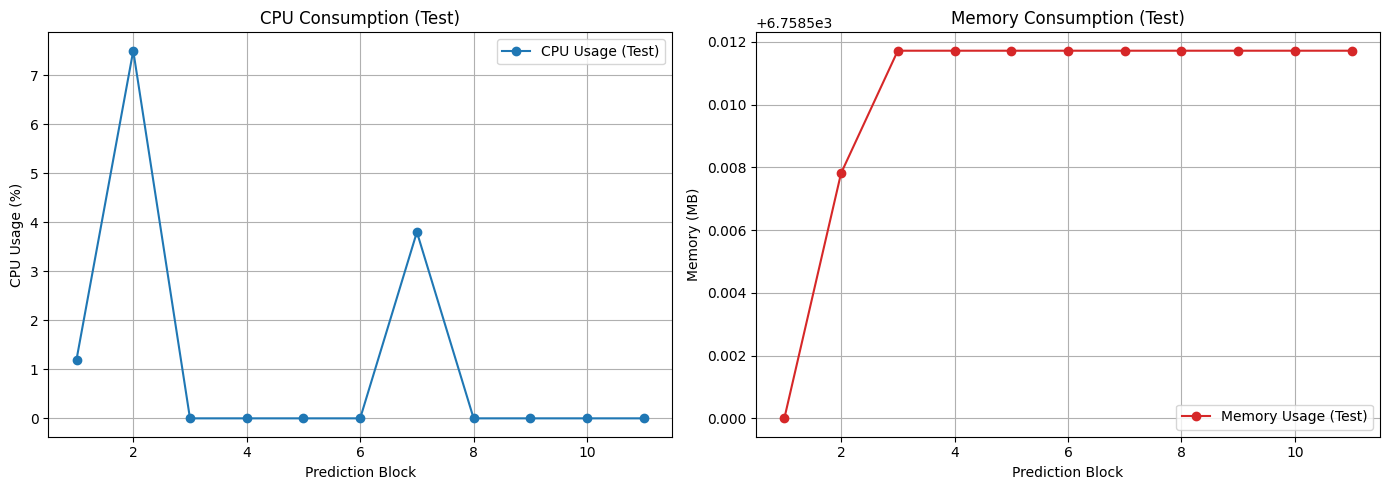

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10774/10774 ━━━━━━━━━━━━━━━━━━━━ 11s 989us/step
STD do reconstruction error: 166.64290496810003
ROC FULL gerada com AUC=0.5995
10774/10774 ━━━━━━━━━━━━━━━━━━━━ 11s 996us/step
STD do reconstruction error: 166.64290496810003
PR FULL gerada com AP=0.9185

====== Zero-Day: sql_injection ======
Total sql_injection in the original dataset: 1763
  Zero-days removed from training: 1427
  Zero-day in the original test: 336
  Test full total: 344764

[Start of Training]

[Epoch 1 - Start] CPU: 0.00%, Memory: 7331.47 MB
[Epoch 1 - End] CPU: 0.00%, Memory: 6802.21 MB

[Epoch 2 - Start] CPU: 6.20%, Memory: 6794.29 MB
[Epoch 2 - End] CPU: 0.00%, Memory: 6876.60 MB

[Epoch 3 - Start] CPU: 0.00%, Memory: 6876.58 MB
[Epoch 3 - End] CPU: 0.00%, Memory: 6883.28 MB

[Epoch 4 - Start] CPU: 2.50%, Memory: 6883.26 MB
[Epoch 4 - End] CPU: 1.30%, Memory: 6888.96 MB

[Epoch 5 - Start] CPU: 3.70%, Memory: 6888.94 MB
[Epoch 5 - End] CPU: 0.00%, Memory: 6915.42 MB

[End of T

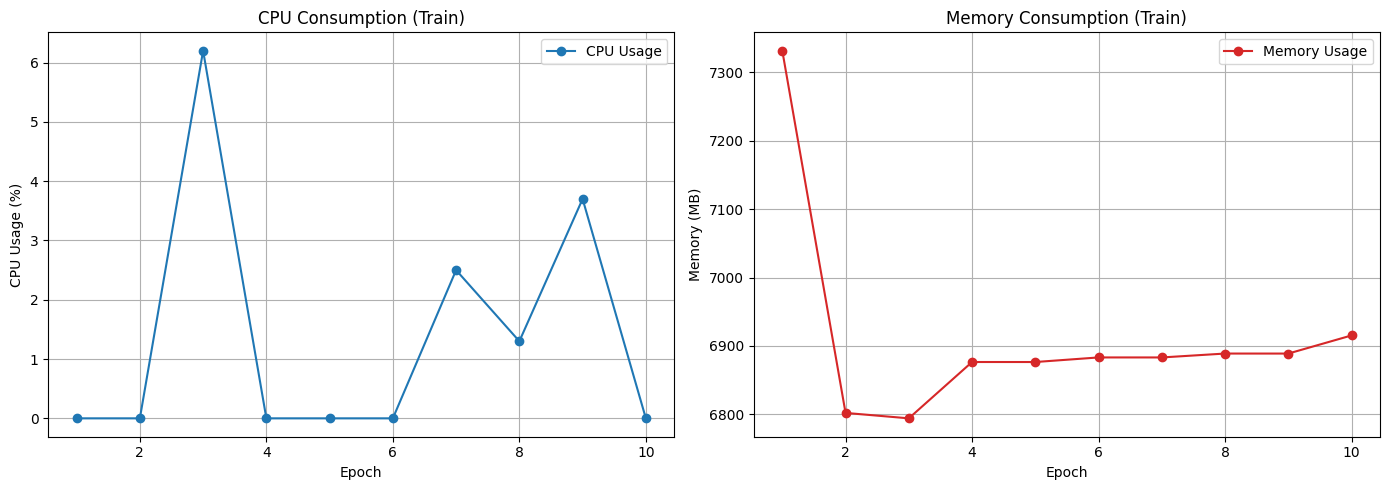

77569/77569 ━━━━━━━━━━━━━━━━━━━━ 67s 868us/step

====== General Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 15.02 seconds
Average CPU usage (Test): 3.16%
Average memory usage (Test): 7089.02 MB
Estimated energy consumption: 3804.38 Joules


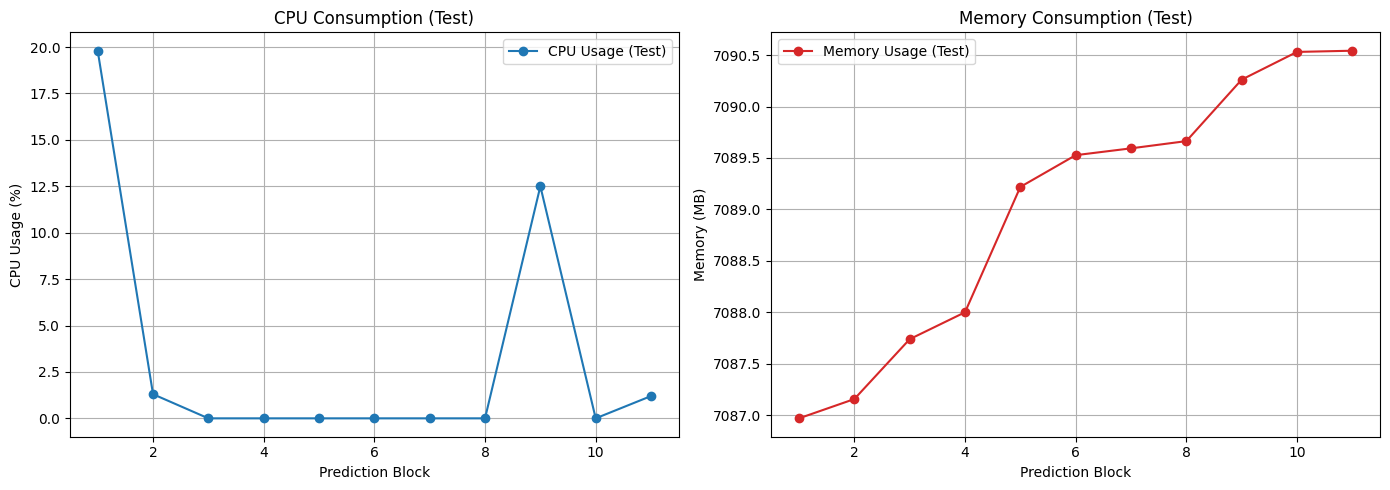

10774/10774 ━━━━━━━━━━━━━━━━━━━━ 10s 957us/step

====== Zero-Day Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 2.17 seconds
Average CPU usage (Test): 0.90%
Average memory usage (Test): 7126.86 MB
Estimated energy consumption: 12.68 Joules


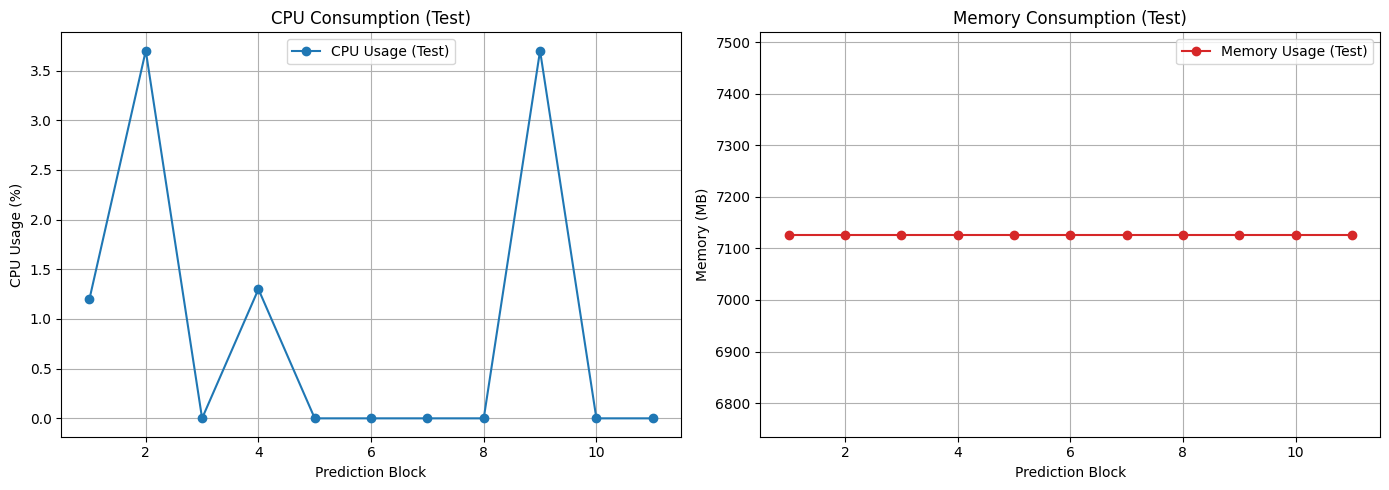

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10774/10774 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
STD do reconstruction error: 166.8381400771067
ROC FULL gerada com AUC=0.5994
10774/10774 ━━━━━━━━━━━━━━━━━━━━ 10s 953us/step
STD do reconstruction error: 166.8381400771067
PR FULL gerada com AP=0.9184


In [ ]:
# ===== IMPORTS =====
import pandas as pd
import numpy as np
import time
import psutil
import gc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import os

# Configuração das features e rótulos
features = [
    'src_port', 'dst_port', 'duration', 'src_bytes', 'dst_bytes', 'missed_bytes',
    'src_pkts', 'src_ip_bytes', 'dst_pkts', 'dst_ip_bytes', 'ip_proto',
    'http_trans_depth', 'files_total_bytes', 'is_GET_mthd',
    'http_status_error', 'is_file_transfered', 'attack_type'
]

X = encoded[features]
y = encoded['Label']  # Coluna de rótulos

# Dividir antes de escolher zero-days
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Guardar Attack Type para separar os zero-days
X_train['attack_type'] = encoded.loc[X_train.index, 'attack_type']
X_test['attack_type'] = encoded.loc[X_test.index, 'attack_type']

# ===== CONFIGURAÇÕES =====
zero_day_attacks = ['tcp_ack', 'syn', 'icmp', 'slowloris', 'udp', 'ssh', 'ftp', 'portscan_tcp', 'os_fingerprinting', 'portscan_udp', 'http_flood', 'dir_bruteforce', 'xss', 'sql_injection']
smote = SMOTE(random_state=42)
scaler = StandardScaler()
label_encoder = LabelEncoder()

model_name = "Autoencoder"
roc_full_curves = []
pr_full_curves = []

resultados_zero_day = []

# ===== LOOP PRINCIPAL =====
for ataque_zero_day in zero_day_attacks:
    print(f"\n====== Zero-Day: {ataque_zero_day} ======")

    # --- Contagem no dataset original ---
    total_in_original = (X['attack_type'] == ataque_zero_day).sum()
    print(f"Total {ataque_zero_day} in the original dataset: {total_in_original}")
    mask_train = X_train['attack_type'] != ataque_zero_day
    train_removed = (~mask_train).sum()

    X_train_clean = X_train.loc[mask_train].drop(columns=['attack_type']).copy()
    y_train_clean = y_train.loc[mask_train].copy()
    print(f"  Zero-days removed from training: {train_removed}")

    mask_test_zero = X_test['attack_type'] == ataque_zero_day
    X_test_zero_day = X_test.loc[mask_test_zero].drop(columns=['attack_type']).copy()
    y_test_zero_day = y_test.loc[mask_test_zero].copy()
    print(f"  Zero-day in the original test: {mask_test_zero.sum()}")

    X_test_full = X_test.drop(columns=['attack_type']).copy()
    y_test_full = y_test.copy()
    print(f"  Test full total: {len(X_test_full)}")

    # --- Balanceamento com SMOTE ---
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_clean, y_train_clean)

    # --- Normalização ---
    X_train_scaled = scaler.fit_transform(X_train_balanced)
    X_test_full_scaled = scaler.transform(X_test_full)
    X_test_zero_day_scaled = scaler.transform(X_test_zero_day)

    # --- Construção do Autoencoder ---
    input_dim = X_train_scaled.shape[1]
    encoding_dim = 32  # latente

    input_layer = Input(shape=(input_dim,))
    encoded = Dense(64, activation="relu")(input_layer)
    encoded = Dense(encoding_dim, activation="relu")(encoded)
    decoded = Dense(64, activation="relu")(encoded)
    output_layer = Dense(input_dim, activation="sigmoid")(decoded)

    autoencoder = Model(input_layer, output_layer)
    autoencoder.compile(optimizer="adam", loss="mse")

    # --- Treinamento com monitoramento ---
    history = autoencoder.fit(
        X_train_scaled, X_train_scaled,
        epochs=20,
        batch_size=128,
        validation_split=0.2,
        callbacks=[early_stopping, reduce_lr, resource_monitor],
        verbose=0
    )

    # =============================
    # Definir threshold (a partir do treino benigno)
    # =============================
    recon_train = autoencoder.predict(X_train_scaled)
    train_errors = np.mean(np.power(X_train_scaled - recon_train, 2), axis=1)
    threshold = np.percentile(train_errors, 70)

    # =============================
    # Função para calcular métricas
    # =============================
    def avaliar(autoencoder, X, y_true, threshold):
        recon = autoencoder.predict(X)
        errors = np.mean(np.power(X - recon, 2), axis=1)
        y_pred = (errors > threshold).astype(int)
        return {
            "F1": f1_score(y_true, y_pred, zero_division=1),
            "Precision": precision_score(y_true, y_pred, zero_division=1),
            "Recall": recall_score(y_true, y_pred, zero_division=1),
            "Accuracy": accuracy_score(y_true, y_pred)
        }

    # =============================
    # Codificação dos rótulos
    # =============================
    y_test_full_encoded = y_test_full
    y_test_zero_day_encoded = y_test_zero_day

    y_test_full_encoded = y_test_full
    y_test_zero_day_encoded = y_test_zero_day

    # =============================
    # TESTE GERAL COM MONITORAMENTO
    # =============================
    print('\n====== General Resource Allocation ======')
    metrics_test_full = monitor_test_prediction(autoencoder, X_test_full_scaled)
    result_full = avaliar(autoencoder, X_test_full_scaled, y_test_full_encoded, threshold)

    # =============================
    # TESTE ZERO-DAY COM MONITORAMENTO
    # =============================
    print('\n====== Zero-Day Resource Allocation ======')
    metrics_zero_day = monitor_test_prediction(autoencoder, X_test_zero_day_scaled)
    result_zero = avaliar(autoencoder, X_test_zero_day_scaled, y_test_zero_day_encoded, threshold)

    # =============================
    # Salvar resultados
    # =============================
    resultados_zero_day.append({
    'Attack Zero-Day': ataque_zero_day,

    'Accuracy': result_full['Accuracy'],
    'F1': result_full['F1'],
    'Precision': result_full['Precision'],
    'Recall': result_full['Recall'],
    'Time': metrics_test_full['total_time'],
    'CPU': metrics_test_full['avg_cpu'],
    'Memory': metrics_test_full['avg_mem'],
    'Energy': metrics_test_full['energia'],

    'ZD - Accuracy': result_zero['Accuracy'],
    'ZD - F1': result_zero['F1'],
    'ZD - Precision': result_zero['Precision'],
    'ZD - Recall': result_zero['Recall'],
    'ZD - Time': metrics_zero_day['total_time'],
    'ZD - CPU': metrics_zero_day['avg_cpu'],
    'ZD - Memory': metrics_zero_day['avg_mem'],
    'ZD - Energy': metrics_zero_day['energia'],
  })
    # =============================
    # CURVA ROC (AUTOENCODER) - TESTE FULL
    # =============================

    # Predição
    X_pred = autoencoder.predict(X_test_full_scaled)

    # Erro por amostra
    reconstruction_error = np.mean(np.square(X_test_full_scaled - X_pred), axis=1)

    # Verificação de valores constantes (debug)
    print("STD reconstruction error:", np.std(reconstruction_error))

    # Score contínuo
    probs_full = reconstruction_error

    # Geração da ROC
    fpr_full, tpr_full, _ = roc_curve(y_test_full_encoded, probs_full)
    roc_auc_full = auc(fpr_full, tpr_full)

    roc_full_curves.append((fpr_full, tpr_full, roc_auc_full, ataque_zero_day))

    print(f"ROC FULL={roc_auc_full:.4f}")

    # =============================
    # PR CURVE (AUTOENCODER) - TESTE FULL
    # =============================

    # Predição
    X_pred = autoencoder.predict(X_test_full_scaled)

    # Erro por amostra
    reconstruction_error = np.mean(np.square(X_test_full_scaled - X_pred), axis=1)

    # Verificação de valores constantes (debug)
    print("STD reconstruction error:", np.std(reconstruction_error))

    # Score contínuo (maior erro = maior chance de ataque)
    probs_full = reconstruction_error

    # Geração da PR-Curve
    precision_full, recall_full, _ = precision_recall_curve(y_test_full_encoded, probs_full)
    ap_full = average_precision_score(y_test_full_encoded, probs_full)

    # Armazena no array geral igual à ROC
    pr_full_curves.append((precision_full, recall_full, ap_full, ataque_zero_day))

    print(f"PR FULL={ap_full:.4f}")

    del autoencoder
    gc.collect()
    K.clear_session()

/tmp/ipython-input-1070250525.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(roc_full_curves))


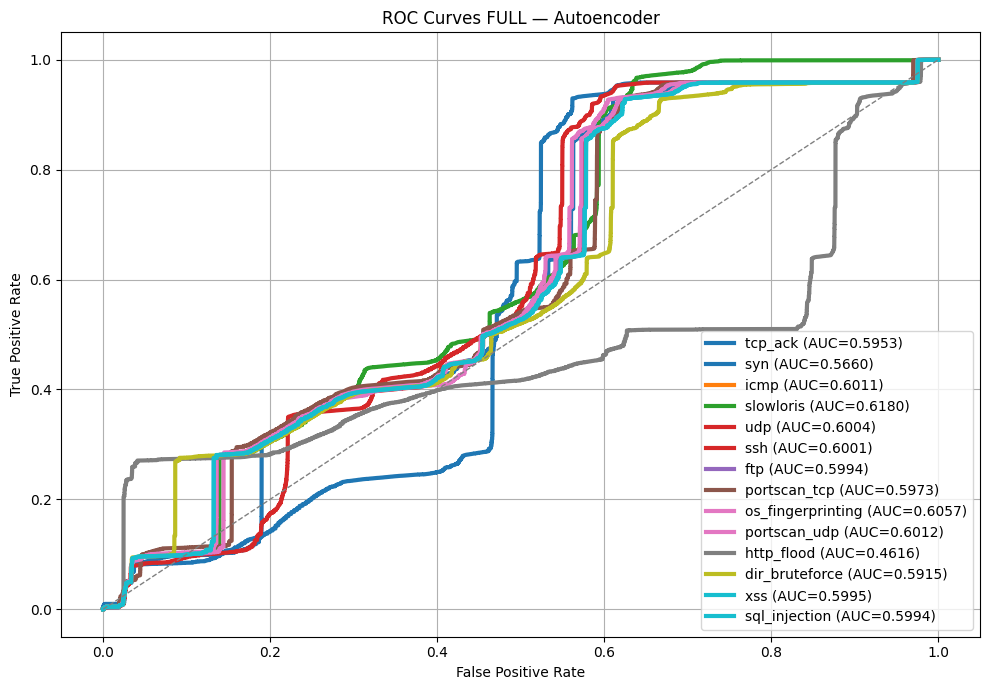

In [ ]:
# =========================================
# Após o loop, gera um gráfico com todas as curvas FULL
# =========================================
plt.figure(figsize=(10, 7))
colors = plt.cm.get_cmap('tab10', len(roc_full_curves))

for i, (fpr, tpr, auc_val, label) in enumerate(roc_full_curves):
    plt.plot(fpr, tpr, lw=3, color=colors(i), label=f"{label} (AUC={auc_val:.4f})")

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curves FULL — {model_name}')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
os.makedirs("roc_curves", exist_ok=True)
plt.savefig(f"roc_curves/{model_name}_ALL_FULL_ROC.png", dpi=400)
plt.show()

/tmp/ipython-input-3286749372.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(pr_full_curves))


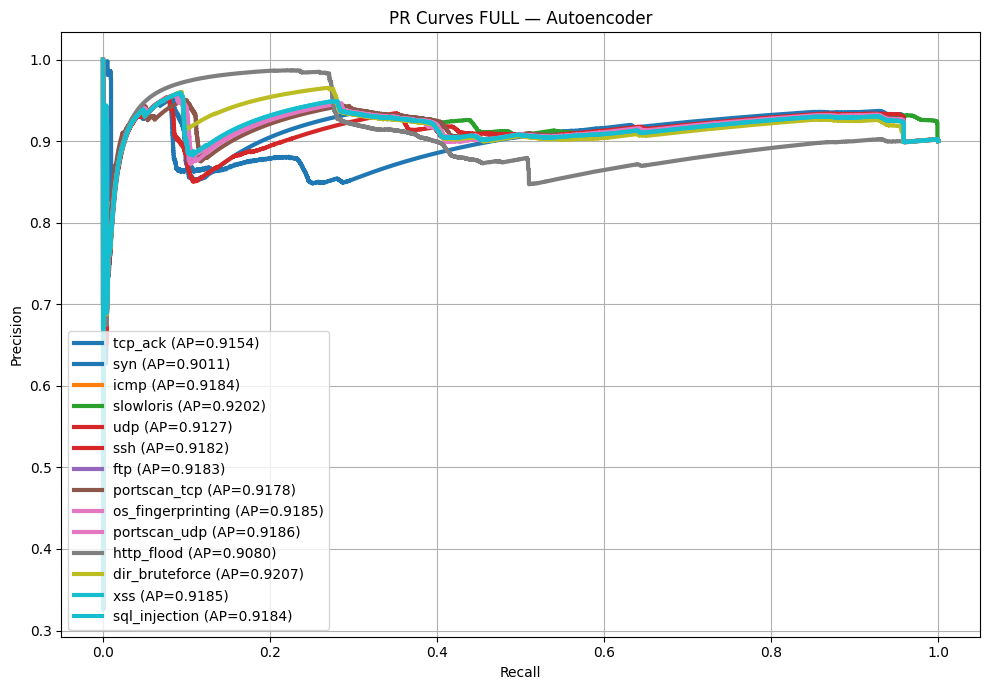

In [ ]:
# =========================================
# Após o loop, gera um gráfico com todas as PR CURVES (FULL)
# =========================================
plt.figure(figsize=(10, 7))
colors = plt.cm.get_cmap('tab10', len(pr_full_curves))

for i, (precision, recall, ap_val, label) in enumerate(pr_full_curves):
    plt.plot(recall, precision, lw=3, color=colors(i),
             label=f"{label} (AP={ap_val:.4f})")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'PR Curves FULL — {model_name}')
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()

os.makedirs("pr_curves", exist_ok=True)
plt.savefig(f"pr_curves/{model_name}_ALL_FULL_PR.png", dpi=400)
plt.show()


In [ ]:
!pip install tabulate

In [ ]:
import pandas as pd
from tabulate import tabulate

df_resultados = pd.DataFrame(resultados_zero_day)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 180)
pd.set_option('display.float_format', '{:.4f}'.format)

print(tabulate(df_resultados, headers='keys', tablefmt='fancy_grid', showindex=False))

╒═══════════════════╤════════════╤══════════╤═════════════╤══════════╤═════════╤═════════╤══════════╤══════════╤═════════════════╤═══════════╤══════════════════╤═══════════════╤═════════════╤════════════╤═══════════════╤═══════════════╕
│ Attack Zero-Day   │   Accuracy │       F1 │   Precision │   Recall │    Time │     CPU │   Memory │   Energy │   ZD - Accuracy │   ZD - F1 │   ZD - Precision │   ZD - Recall │   ZD - Time │   ZD - CPU │   ZD - Memory │   ZD - Energy │
╞═══════════════════╪════════════╪══════════╪═════════════╪══════════╪═════════╪═════════╪══════════╪══════════╪═════════════════╪═══════════╪══════════════════╪═══════════════╪═════════════╪════════════╪═══════════════╪═══════════════╡
│ tcp_ack           │   0.389443 │ 0.506471 │    0.930398 │ 0.347937 │ 12.8355 │ 2.24545 │  5494.71 │ 1162.56  │       0.251453  │  0.401857 │                1 │     0.251453  │     3.03845 │   0.554545 │       5318.15 │       4.14527 │
├───────────────────┼────────────┼──────────┼───────

In [ ]:
df_resultados.to_csv('resultados_zero_day_formatado.csv', index=False, float_format='%.4f')